# Detecting spouse mentions in sentences

We will walk through an example text classification task to explore how Snorkel can be used for Information Extraction.
## Classification Task
<img src="imgs/sentence.jpg" width="700px;">

We want to classify each __candidate__ or pair of people mentioned in a sentence, as being married at some point or not.

In the above example, our candidate represents the possible relation `(Barack Obama, Michelle Obama)`. As readers, we know this mention is true due to external knowledge and the keyword of `wedding` occuring later in the sentence.
We begin with some basic setup and data downloading.


In [1]:
%matplotlib inline

import os
import pickle
import numpy as np

if os.path.basename(os.getcwd()) == "snorkel-tutorials":
    os.chdir("spouse")

from utils import load_data

((df_dev, Y_dev), df_train, (df_test, Y_test)) = load_data()

**Input Data:** `df_dev` is a Pandas DataFrame object, where each row represents a particular __candidate__. The DataFrames contain the fields `sentence`, which refers to the sentence the candidate is in, `tokens`, the tokenized form of the sentence, `person1_word_idx` and `person2_word_idx`, which represent `[start, end]` indices in the tokens at which the first and second person's name appear, respectively.

We also have certain **preprocessed fields**, that we discuss a few cells below.

In [2]:
import pandas as pd

# Don't truncate text fields in the display
pd.set_option("display.max_colwidth", 0)

df_dev.head()

,person1_word_idx,person2_word_idx,sentence,tokens,person1_right_tokens,person2_right_tokens,between_tokens
0,"(1, 1)","(22, 24)","The Richards are half-sisters to Kathy Hilton, the mother of socialite Paris Hilton and spouse of luxury hotel magnate Richard Howard Hilton.","[The, Richards, are, half, -, sisters, to, Kathy, Hilton, ,, the, mother, of, socialite, Paris, Hilton, and, spouse, of, luxury, hotel, magnate, Richard, Howard, Hilton, ., ]","[are, half, -, sisters]","[., ]","[are, half, -, sisters, to, Kathy, Hilton, ,, the, mother, of, socialite, Paris, Hilton, and, spouse, of, luxury, hotel, magnate]"
1,"(1, 1)","(7, 8)","The Richards are half-sisters to Kathy Hilton, the mother of socialite Paris Hilton and spouse of luxury hotel magnate Richard Howard Hilton.","[The, Richards, are, half, -, sisters, to, Kathy, Hilton, ,, the, mother, of, socialite, Paris, Hilton, and, spouse, of, luxury, hotel, magnate, Richard, Howard, Hilton, ., ]","[are, half, -, sisters]","[,, the, mother, of]","[are, half, -, sisters, to]"
2,"(7, 8)","(22, 24)","The Richards are half-sisters to Kathy Hilton, the mother of socialite Paris Hilton and spouse of luxury hotel magnate Richard Howard Hilton.","[The, Richards, are, half, -, sisters, to, Kathy, Hilton, ,, the, mother, of, socialite, Paris, Hilton, and, spouse, of, luxury, hotel, magnate, Richard, Howard, Hilton, ., ]","[,, the, mother, of]","[., ]","[,, the, mother, of, socialite, Paris, Hilton, and, spouse, of, luxury, hotel, magnate]"
3,"(6, 6)","(20, 21)","Prior to both his guests, Colbert's monologue - parts of which he did sitting down - ripped into Donald Trump and his oft-mocked policy of building a wall at the US-Mexico border and not eating Oreos anymore.","[Prior, to, both, his, guests, ,, Colbert, s, monologue, -, parts, of, which, he, did, sitting, down, -, ripped, into, Donald, Trump, and, his, oft, -, mocked, policy, of, building, a, wall, at, the, US, -, Mexico, border, and, not, eating, Oreos, anymore, ., ]","[s, monologue, -, parts]","[and, his, oft, -]","[s, monologue, -, parts, of, which, he, did, sitting, down, -, ripped, into]"
4,"(2, 2)","(4, 5)","People reported Williams and Ven Veen tied the knot Saturday at Brush Creek Ranch in Saratoga, Wyoming, in front of about 200 guests.","[People, reported, Williams, and, Ven, Veen, tied, the, knot, Saturday, at, Brush, Creek, Ranch, in, Saratoga, ,, Wyoming, ,, in, front, of, about, 200, guests, .]","[and, Ven, Veen, tied]","[tied, the, knot, Saturday]",[and]


Let's look at a candidate in the development set:

In [3]:
from preprocessors import get_person_text

candidate = df_dev.loc[2]
person_names = get_person_text(candidate).person_names

print("Sentence: ", candidate["sentence"])
print("Person 1: ", person_names[0])
print("Person 2: ", person_names[1])

Sentence:  The Richards are half-sisters to Kathy Hilton, the mother of socialite Paris Hilton and spouse of luxury hotel magnate Richard Howard Hilton.   
Person 1:  Kathy Hilton
Person 2:  Richard Howard Hilton


### Preprocessing the Database

In a real application, there is a lot of data preparation, parsing, and database loading that needs to be completed before we generate candidates and dive into writing labeling functions. Here we've pre-generated candidates in a pandas DataFrame object per split (train,dev,test).

### Labeling Function Helpers

When writing labeling functions, there are several operators you will use over and over again. In the case of text relation extraction as with this task, common operators include fetching text between mentions of the two people in a candidate, examing word windows around person mentions, etc. We will wrap these operators as `preprocessors`.

In [4]:
from snorkel.preprocess import preprocessor


@preprocessor()
def get_text_between(cand):
    """
    Returns the text between the two person mentions in the sentence for a candidate
    """
    start = cand.person1_word_idx[1] + 1
    end = cand.person2_word_idx[0]
    cand.text_between = " ".join(cand.tokens[start:end])
    return cand

### Candidate PreProcessors

We provide a set of `preprocessor`s for this task in `preprocessors.py`. For the purpose of the tutorial, we also have three fields (between_tokens, person1_right_tokens, person2_right_tokens) preprocessed in the data, which can be used when creating labeling functions.

`get_person_text(cand)`

`get_person_lastnames(cand)`

`get_left_tokens(cand)`

In [5]:
from preprocessors import get_left_tokens, get_person_last_names

POSITIVE = 1
NEGATIVE = 0
ABSTAIN = -1

In [6]:
from snorkel.labeling.lf import labeling_function

# Check for the `spouse` words appearing between the person mentions
spouses = {"spouse", "wife", "husband", "ex-wife", "ex-husband"}


@labeling_function(resources=dict(spouses=spouses))
def lf_husband_wife(x, spouses):
    return POSITIVE if len(spouses.intersection(set(x.between_tokens))) > 0 else ABSTAIN

In [7]:
# Check for the `spouse` words appearing to the left of the person mentions
@labeling_function(resources=dict(spouses=spouses), pre=[get_left_tokens])
def lf_husband_wife_left_window(x, spouses):
    if len(set(spouses).intersection(set(x.person1_left_tokens))) > 0:
        return POSITIVE
    elif len(set(spouses).intersection(set(x.person2_left_tokens))) > 0:
        return POSITIVE
    else:
        return ABSTAIN

In [8]:
# Check for the person mentions having the same last name
@labeling_function(pre=[get_person_last_names])
def lf_same_last_name(x):
    p1_ln, p2_ln = x.person_lastnames

    if p1_ln and p2_ln and p1_ln == p2_ln:
        return POSITIVE
    return ABSTAIN

In [9]:
# Check for the word `married` between person mentions
@labeling_function()
def lf_married(x):
    return POSITIVE if "married" in x.between_tokens else ABSTAIN

In [10]:
# Check for words that refer to `family` relationships between and to the left of the person mentions
family = {
    "father",
    "mother",
    "sister",
    "brother",
    "son",
    "daughter",
    "grandfather",
    "grandmother",
    "uncle",
    "aunt",
    "cousin",
}
family = family.union({f + "-in-law" for f in family})


@labeling_function(resources=dict(family=family))
def lf_familial_relationship(x, family):
    return NEGATIVE if len(family.intersection(set(x.between_tokens))) > 0 else ABSTAIN


@labeling_function(resources=dict(family=family), pre=[get_left_tokens])
def lf_family_left_window(x, family):
    if len(set(family).intersection(set(x.person1_left_tokens))) > 0:
        return NEGATIVE
    elif len(set(family).intersection(set(x.person2_left_tokens))) > 0:
        return NEGATIVE
    else:
        return ABSTAIN

In [11]:
# Check for `other` relationship words between person mentions
other = {"boyfriend", "girlfriend", "boss", "employee", "secretary", "co-worker"}


@labeling_function(resources=dict(other=other))
def lf_other_relationship(x, other):
    return NEGATIVE if len(other.intersection(set(x.between_tokens))) > 0 else ABSTAIN

### Distant Supervision Labeling Functions

In addition to using factories that encode pattern matching heuristics, we can also write labeling functions that _distantly supervise_ examples. Here, we'll load in a list of known spouse pairs and check to see if the pair of persons in a candidate matches one of these.

**DBpedia**
http://wiki.dbpedia.org/
Our database of known spouses comes from DBpedia, which is a community-driven resource similar to Wikipedia but for curating structured data. We'll use a preprocessed snapshot as our knowledge base for all labeling function development.

We can look at some of the example entries from DBPedia and use them in a simple distant supervision labeling function.

Make sure `dbpedia.pkl` is in the `spouse/data` directory.

In [12]:
with open("data/dbpedia.pkl", "rb") as f:
    known_spouses = pickle.load(f)

list(known_spouses)[0:5]

[('Joan de Geneville', 'Roger Mortimer'),
 ('Hampton Pitts Fulmer', 'Willa Lybrand Fulmer'),
 ('Mahendra Bir Bikram Shah', 'Queen Ratna'),
 ('Jagriti Chadha', 'Raja Choudhury'),
 ('Isabella of Gloucester and Hertford', 'Robert V de Brus')]

In [13]:
@labeling_function(resources=dict(known_spouses=known_spouses), pre=[get_person_text])
def lf_distant_supervision(x, known_spouses):
    p1, p2 = x.person_names
    if (p1, p2) in known_spouses or (p2, p1) in known_spouses:
        return POSITIVE
    else:
        return ABSTAIN

In [14]:
from preprocessors import last_name

# Last name pairs for known spouses
last_names = set(
    [
        (last_name(x), last_name(y))
        for x, y in known_spouses
        if last_name(x) and last_name(y)
    ]
)


@labeling_function(resources=dict(last_names=last_names), pre=[get_person_last_names])
def lf_distant_supervision_last_names(x, last_names):
    p1_ln, p2_ln = x.person_lastnames

    return (
        POSITIVE
        if (p1_ln != p2_ln)
        and ((p1_ln, p2_ln) in last_names or (p2_ln, p1_ln) in last_names)
        else ABSTAIN
    )

#### Apply Labeling Functions to the Data
We create a list of labeling functions and apply them to the data

In [15]:
from snorkel.labeling.apply import PandasLFApplier

lfs = [
    lf_husband_wife,
    lf_husband_wife_left_window,
    lf_same_last_name,
    lf_married,
    lf_familial_relationship,
    lf_family_left_window,
    lf_other_relationship,
    lf_distant_supervision,
    lf_distant_supervision_last_names,
]
applier = PandasLFApplier(lfs)

In [16]:
from snorkel.labeling.analysis import LFAnalysis

dev_L = applier.apply(df_dev)
train_L = applier.apply(df_train)

LFAnalysis(dev_L, lfs).lf_summary(Y_dev)

  0%|          | 0/2811 [00:00<?, ?it/s]

  1%|▏         | 38/2811 [00:00<00:07, 374.09it/s]

  3%|▎         | 76/2811 [00:00<00:07, 375.44it/s]

  4%|▍         | 115/2811 [00:00<00:07, 377.25it/s]

  5%|▌         | 153/2811 [00:00<00:07, 376.78it/s]

  7%|▋         | 191/2811 [00:00<00:06, 375.87it/s]

  8%|▊         | 228/2811 [00:00<00:06, 373.93it/s]

  9%|▉         | 266/2811 [00:00<00:06, 374.93it/s]

 11%|█         | 304/2811 [00:00<00:06, 375.79it/s]

 12%|█▏        | 341/2811 [00:00<00:06, 371.44it/s]

 13%|█▎        | 379/2811 [00:01<00:06, 371.75it/s]

 15%|█▍        | 416/2811 [00:01<00:06, 371.18it/s]

 16%|█▌        | 454/2811 [00:01<00:06, 373.77it/s]

 18%|█▊        | 492/2811 [00:01<00:06, 374.83it/s]

 19%|█▉        | 530/2811 [00:01<00:06, 375.88it/s]

 20%|██        | 568/2811 [00:01<00:06, 372.98it/s]

 22%|██▏       | 606/2811 [00:01<00:05, 373.16it/s]

 23%|██▎       | 645/2811 [00:01<00:05, 376.40it/s]

 24%|██▍       | 683/2811 [00:01<00:05, 375.39it/s]

 26%|██▌       | 721/2811 [00:01<00:05, 376.02it/s]

 27%|██▋       | 760/2811 [00:02<00:05, 377.05it/s]

 28%|██▊       | 798/2811 [00:02<00:05, 376.76it/s]

 30%|██▉       | 836/2811 [00:02<00:05, 377.66it/s]

 31%|███       | 874/2811 [00:02<00:05, 376.37it/s]

 32%|███▏      | 913/2811 [00:02<00:05, 377.75it/s]

 34%|███▍      | 952/2811 [00:02<00:04, 378.61it/s]

 35%|███▌      | 990/2811 [00:02<00:04, 377.67it/s]

 37%|███▋      | 1028/2811 [00:02<00:04, 375.96it/s]

 38%|███▊      | 1066/2811 [00:02<00:04, 375.70it/s]

 39%|███▉      | 1104/2811 [00:02<00:04, 375.17it/s]

 41%|████      | 1142/2811 [00:03<00:04, 376.03it/s]

 42%|████▏     | 1181/2811 [00:03<00:04, 377.37it/s]

 43%|████▎     | 1219/2811 [00:03<00:04, 376.66it/s]

 45%|████▍     | 1257/2811 [00:03<00:04, 376.85it/s]

 46%|████▌     | 1295/2811 [00:03<00:04, 376.57it/s]

 47%|████▋     | 1334/2811 [00:03<00:03, 377.89it/s]

 49%|████▉     | 1373/2811 [00:03<00:03, 379.11it/s]

 50%|█████     | 1411/2811 [00:03<00:03, 379.23it/s]

 52%|█████▏    | 1449/2811 [00:03<00:03, 379.25it/s]

 53%|█████▎    | 1487/2811 [00:03<00:03, 378.26it/s]

 54%|█████▍    | 1525/2811 [00:04<00:03, 377.63it/s]

 56%|█████▌    | 1563/2811 [00:04<00:03, 377.86it/s]

 57%|█████▋    | 1601/2811 [00:04<00:03, 377.09it/s]

 58%|█████▊    | 1639/2811 [00:04<00:03, 377.03it/s]

 60%|█████▉    | 1677/2811 [00:04<00:03, 376.82it/s]

 61%|██████    | 1715/2811 [00:04<00:02, 375.18it/s]

 62%|██████▏   | 1754/2811 [00:04<00:02, 376.92it/s]

 64%|██████▎   | 1792/2811 [00:04<00:02, 375.82it/s]

 65%|██████▌   | 1830/2811 [00:04<00:02, 374.81it/s]

 66%|██████▋   | 1869/2811 [00:04<00:02, 377.34it/s]

 68%|██████▊   | 1908/2811 [00:05<00:02, 378.51it/s]

 69%|██████▉   | 1947/2811 [00:05<00:02, 379.73it/s]

 71%|███████   | 1985/2811 [00:05<00:02, 379.56it/s]

 72%|███████▏  | 2023/2811 [00:05<00:02, 376.18it/s]

 73%|███████▎  | 2061/2811 [00:05<00:02, 373.67it/s]

 75%|███████▍  | 2099/2811 [00:05<00:01, 374.20it/s]

 76%|███████▌  | 2138/2811 [00:05<00:01, 376.00it/s]

 77%|███████▋  | 2176/2811 [00:05<00:01, 375.97it/s]

 79%|███████▉  | 2214/2811 [00:05<00:01, 376.90it/s]

 80%|████████  | 2252/2811 [00:05<00:01, 377.30it/s]

 81%|████████▏ | 2290/2811 [00:06<00:01, 376.24it/s]

 83%|████████▎ | 2328/2811 [00:06<00:01, 376.37it/s]

 84%|████████▍ | 2366/2811 [00:06<00:01, 373.66it/s]

 86%|████████▌ | 2404/2811 [00:06<00:01, 375.42it/s]

 87%|████████▋ | 2442/2811 [00:06<00:00, 375.67it/s]

 88%|████████▊ | 2481/2811 [00:06<00:00, 377.19it/s]

 90%|████████▉ | 2519/2811 [00:06<00:00, 378.01it/s]

 91%|█████████ | 2558/2811 [00:06<00:00, 379.32it/s]

 92%|█████████▏| 2596/2811 [00:06<00:00, 378.62it/s]

 94%|█████████▎| 2635/2811 [00:06<00:00, 379.18it/s]

 95%|█████████▌| 2673/2811 [00:07<00:00, 378.68it/s]

 96%|█████████▋| 2712/2811 [00:07<00:00, 379.18it/s]

 98%|█████████▊| 2750/2811 [00:07<00:00, 377.76it/s]

 99%|█████████▉| 2789/2811 [00:07<00:00, 378.86it/s]

100%|██████████| 2811/2811 [00:07<00:00, 376.47it/s]


  0%|          | 0/22254 [00:00<?, ?it/s]

  0%|          | 35/22254 [00:00<01:04, 345.25it/s]

  0%|          | 73/22254 [00:00<01:02, 353.39it/s]

  0%|          | 111/22254 [00:00<01:01, 359.90it/s]

  1%|          | 149/22254 [00:00<01:00, 363.77it/s]

  1%|          | 187/22254 [00:00<01:00, 366.84it/s]

  1%|          | 225/22254 [00:00<00:59, 370.45it/s]

  1%|          | 264/22254 [00:00<00:58, 373.64it/s]

  1%|▏         | 302/22254 [00:00<00:58, 375.37it/s]

  2%|▏         | 340/22254 [00:00<00:58, 375.80it/s]

  2%|▏         | 377/22254 [00:01<00:58, 374.01it/s]

  2%|▏         | 415/22254 [00:01<00:58, 374.47it/s]

  2%|▏         | 453/22254 [00:01<00:57, 376.11it/s]

  2%|▏         | 491/22254 [00:01<00:57, 376.98it/s]

  2%|▏         | 529/22254 [00:01<00:57, 374.65it/s]

  3%|▎         | 567/22254 [00:01<00:58, 370.61it/s]

  3%|▎         | 605/22254 [00:01<00:58, 372.74it/s]

  3%|▎         | 643/22254 [00:01<00:57, 374.23it/s]

  3%|▎         | 681/22254 [00:01<00:57, 372.25it/s]

  3%|▎         | 719/22254 [00:01<00:57, 373.95it/s]

  3%|▎         | 757/22254 [00:02<00:57, 375.68it/s]

  4%|▎         | 795/22254 [00:02<00:57, 374.25it/s]

  4%|▎         | 833/22254 [00:02<00:57, 375.59it/s]

  4%|▍         | 871/22254 [00:02<00:56, 375.96it/s]

  4%|▍         | 909/22254 [00:02<00:56, 377.15it/s]

  4%|▍         | 947/22254 [00:02<00:56, 377.83it/s]

  4%|▍         | 985/22254 [00:02<00:56, 378.15it/s]

  5%|▍         | 1023/22254 [00:02<00:56, 376.12it/s]

  5%|▍         | 1061/22254 [00:02<00:56, 376.58it/s]

  5%|▍         | 1099/22254 [00:02<00:56, 376.04it/s]

  5%|▌         | 1137/22254 [00:03<00:56, 374.34it/s]

  5%|▌         | 1175/22254 [00:03<00:56, 375.57it/s]

  5%|▌         | 1213/22254 [00:03<00:56, 375.01it/s]

  6%|▌         | 1251/22254 [00:03<00:55, 375.93it/s]

  6%|▌         | 1290/22254 [00:03<00:55, 377.77it/s]

  6%|▌         | 1328/22254 [00:03<00:55, 378.02it/s]

  6%|▌         | 1366/22254 [00:03<00:55, 377.99it/s]

  6%|▋         | 1404/22254 [00:03<00:55, 373.26it/s]

  6%|▋         | 1442/22254 [00:03<00:55, 372.34it/s]

  7%|▋         | 1480/22254 [00:03<00:55, 371.34it/s]

  7%|▋         | 1518/22254 [00:04<00:55, 372.63it/s]

  7%|▋         | 1556/22254 [00:04<00:55, 373.20it/s]

  7%|▋         | 1594/22254 [00:04<00:55, 371.94it/s]

  7%|▋         | 1632/22254 [00:04<00:55, 373.55it/s]

  8%|▊         | 1670/22254 [00:04<00:55, 372.79it/s]

  8%|▊         | 1708/22254 [00:04<00:55, 373.51it/s]

  8%|▊         | 1746/22254 [00:04<00:54, 373.31it/s]

  8%|▊         | 1784/22254 [00:04<00:54, 374.18it/s]

  8%|▊         | 1823/22254 [00:04<00:54, 375.91it/s]

  8%|▊         | 1861/22254 [00:04<00:54, 376.94it/s]

  9%|▊         | 1899/22254 [00:05<00:54, 375.53it/s]

  9%|▊         | 1937/22254 [00:05<00:55, 367.25it/s]

  9%|▉         | 1975/22254 [00:05<00:54, 369.92it/s]

  9%|▉         | 2013/22254 [00:05<00:54, 371.19it/s]

  9%|▉         | 2051/22254 [00:05<00:54, 372.79it/s]

  9%|▉         | 2089/22254 [00:05<00:53, 374.16it/s]

 10%|▉         | 2127/22254 [00:05<00:53, 373.66it/s]

 10%|▉         | 2165/22254 [00:05<00:53, 372.97it/s]

 10%|▉         | 2203/22254 [00:05<00:53, 372.40it/s]

 10%|█         | 2241/22254 [00:05<00:53, 374.23it/s]

 10%|█         | 2280/22254 [00:06<00:53, 376.38it/s]

 10%|█         | 2318/22254 [00:06<00:53, 375.84it/s]

 11%|█         | 2356/22254 [00:06<00:53, 374.97it/s]

 11%|█         | 2394/22254 [00:06<00:52, 374.85it/s]

 11%|█         | 2432/22254 [00:06<00:53, 372.69it/s]

 11%|█         | 2470/22254 [00:06<00:52, 373.86it/s]

 11%|█▏        | 2508/22254 [00:06<00:52, 375.60it/s]

 11%|█▏        | 2546/22254 [00:06<00:52, 374.04it/s]

 12%|█▏        | 2584/22254 [00:06<00:52, 374.37it/s]

 12%|█▏        | 2622/22254 [00:07<00:52, 374.57it/s]

 12%|█▏        | 2660/22254 [00:07<00:52, 370.54it/s]

 12%|█▏        | 2698/22254 [00:07<00:52, 370.66it/s]

 12%|█▏        | 2737/22254 [00:07<00:52, 373.52it/s]

 12%|█▏        | 2775/22254 [00:07<00:52, 373.18it/s]

 13%|█▎        | 2813/22254 [00:07<00:52, 373.65it/s]

 13%|█▎        | 2851/22254 [00:07<00:52, 372.64it/s]

 13%|█▎        | 2889/22254 [00:07<00:51, 373.80it/s]

 13%|█▎        | 2927/22254 [00:07<00:51, 375.26it/s]

 13%|█▎        | 2965/22254 [00:07<00:51, 375.83it/s]

 13%|█▎        | 3003/22254 [00:08<00:51, 376.25it/s]

 14%|█▎        | 3041/22254 [00:08<00:51, 374.56it/s]

 14%|█▍        | 3079/22254 [00:08<00:51, 374.73it/s]

 14%|█▍        | 3117/22254 [00:08<00:50, 375.47it/s]

 14%|█▍        | 3155/22254 [00:08<00:51, 374.18it/s]

 14%|█▍        | 3193/22254 [00:08<00:51, 373.15it/s]

 15%|█▍        | 3231/22254 [00:08<00:50, 374.26it/s]

 15%|█▍        | 3269/22254 [00:08<00:50, 375.18it/s]

 15%|█▍        | 3307/22254 [00:08<00:50, 375.94it/s]

 15%|█▌        | 3345/22254 [00:08<00:50, 376.53it/s]

 15%|█▌        | 3383/22254 [00:09<00:50, 374.81it/s]

 15%|█▌        | 3421/22254 [00:09<00:50, 374.88it/s]

 16%|█▌        | 3459/22254 [00:09<00:50, 374.58it/s]

 16%|█▌        | 3497/22254 [00:09<00:50, 372.17it/s]

 16%|█▌        | 3535/22254 [00:09<00:50, 370.97it/s]

 16%|█▌        | 3573/22254 [00:09<00:50, 371.16it/s]

 16%|█▌        | 3611/22254 [00:09<00:50, 372.50it/s]

 16%|█▋        | 3649/22254 [00:09<00:49, 373.13it/s]

 17%|█▋        | 3687/22254 [00:09<00:49, 374.31it/s]

 17%|█▋        | 3725/22254 [00:09<00:49, 374.02it/s]

 17%|█▋        | 3763/22254 [00:10<00:49, 372.08it/s]

 17%|█▋        | 3801/22254 [00:10<00:49, 372.20it/s]

 17%|█▋        | 3839/22254 [00:10<00:49, 372.61it/s]

 17%|█▋        | 3877/22254 [00:10<00:49, 372.37it/s]

 18%|█▊        | 3915/22254 [00:10<00:49, 373.98it/s]

 18%|█▊        | 3953/22254 [00:10<00:48, 373.66it/s]

 18%|█▊        | 3991/22254 [00:10<00:48, 374.20it/s]

 18%|█▊        | 4029/22254 [00:10<00:48, 373.08it/s]

 18%|█▊        | 4067/22254 [00:10<00:48, 374.01it/s]

 18%|█▊        | 4105/22254 [00:10<00:48, 375.05it/s]

 19%|█▊        | 4143/22254 [00:11<00:48, 373.37it/s]

 19%|█▉        | 4181/22254 [00:11<00:48, 374.24it/s]

 19%|█▉        | 4219/22254 [00:11<00:48, 375.64it/s]

 19%|█▉        | 4257/22254 [00:11<00:48, 373.18it/s]

 19%|█▉        | 4295/22254 [00:11<00:48, 373.81it/s]

 19%|█▉        | 4333/22254 [00:11<00:48, 372.22it/s]

 20%|█▉        | 4371/22254 [00:11<00:48, 372.28it/s]

 20%|█▉        | 4409/22254 [00:11<00:47, 371.96it/s]

 20%|█▉        | 4447/22254 [00:11<00:47, 372.70it/s]

 20%|██        | 4485/22254 [00:11<00:47, 371.91it/s]

 20%|██        | 4523/22254 [00:12<00:47, 373.81it/s]

 20%|██        | 4561/22254 [00:12<00:47, 375.50it/s]

 21%|██        | 4599/22254 [00:12<00:47, 375.35it/s]

 21%|██        | 4637/22254 [00:12<00:46, 375.51it/s]

 21%|██        | 4675/22254 [00:12<00:46, 375.37it/s]

 21%|██        | 4713/22254 [00:12<00:46, 374.36it/s]

 21%|██▏       | 4751/22254 [00:12<00:46, 373.96it/s]

 22%|██▏       | 4789/22254 [00:12<00:46, 372.85it/s]

 22%|██▏       | 4828/22254 [00:12<00:46, 374.80it/s]

 22%|██▏       | 4866/22254 [00:13<00:46, 373.16it/s]

 22%|██▏       | 4904/22254 [00:13<00:46, 374.05it/s]

 22%|██▏       | 4942/22254 [00:13<00:46, 374.72it/s]

 22%|██▏       | 4980/22254 [00:13<00:45, 375.81it/s]

 23%|██▎       | 5018/22254 [00:13<00:45, 376.62it/s]

 23%|██▎       | 5056/22254 [00:13<00:45, 376.78it/s]

 23%|██▎       | 5094/22254 [00:13<00:45, 373.68it/s]

 23%|██▎       | 5132/22254 [00:13<00:45, 374.66it/s]

 23%|██▎       | 5170/22254 [00:13<00:45, 375.26it/s]

 23%|██▎       | 5208/22254 [00:13<00:45, 373.17it/s]

 24%|██▎       | 5246/22254 [00:14<00:45, 373.78it/s]

 24%|██▎       | 5284/22254 [00:14<00:45, 373.74it/s]

 24%|██▍       | 5322/22254 [00:14<00:45, 375.32it/s]

 24%|██▍       | 5360/22254 [00:14<00:44, 375.59it/s]

 24%|██▍       | 5398/22254 [00:14<00:44, 375.77it/s]

 24%|██▍       | 5436/22254 [00:14<00:44, 375.69it/s]

 25%|██▍       | 5474/22254 [00:14<00:44, 375.82it/s]

 25%|██▍       | 5512/22254 [00:14<00:44, 376.70it/s]

 25%|██▍       | 5550/22254 [00:14<00:44, 377.57it/s]

 25%|██▌       | 5588/22254 [00:14<00:44, 376.72it/s]

 25%|██▌       | 5626/22254 [00:15<00:44, 375.50it/s]

 25%|██▌       | 5664/22254 [00:15<00:44, 376.57it/s]

 26%|██▌       | 5702/22254 [00:15<00:44, 376.10it/s]

 26%|██▌       | 5740/22254 [00:15<00:43, 375.65it/s]

 26%|██▌       | 5778/22254 [00:15<00:43, 374.99it/s]

 26%|██▌       | 5816/22254 [00:15<00:43, 375.15it/s]

 26%|██▋       | 5854/22254 [00:15<00:43, 374.92it/s]

 26%|██▋       | 5892/22254 [00:15<00:43, 374.92it/s]

 27%|██▋       | 5930/22254 [00:15<00:43, 371.97it/s]

 27%|██▋       | 5968/22254 [00:15<00:43, 372.22it/s]

 27%|██▋       | 6006/22254 [00:16<00:43, 370.58it/s]

 27%|██▋       | 6044/22254 [00:16<00:43, 370.16it/s]

 27%|██▋       | 6082/22254 [00:16<00:43, 369.34it/s]

 27%|██▋       | 6119/22254 [00:16<00:43, 369.29it/s]

 28%|██▊       | 6157/22254 [00:16<00:43, 369.77it/s]

 28%|██▊       | 6194/22254 [00:16<00:43, 368.33it/s]

 28%|██▊       | 6231/22254 [00:16<00:43, 367.84it/s]

 28%|██▊       | 6269/22254 [00:16<00:43, 369.78it/s]

 28%|██▊       | 6307/22254 [00:16<00:42, 371.43it/s]

 29%|██▊       | 6345/22254 [00:16<00:42, 372.48it/s]

 29%|██▊       | 6383/22254 [00:17<00:42, 372.43it/s]

 29%|██▉       | 6421/22254 [00:17<00:42, 373.63it/s]

 29%|██▉       | 6459/22254 [00:17<00:42, 374.03it/s]

 29%|██▉       | 6497/22254 [00:17<00:42, 373.52it/s]

 29%|██▉       | 6535/22254 [00:17<00:41, 375.00it/s]

 30%|██▉       | 6573/22254 [00:17<00:41, 374.94it/s]

 30%|██▉       | 6611/22254 [00:17<00:41, 375.38it/s]

 30%|██▉       | 6649/22254 [00:17<00:41, 374.14it/s]

 30%|███       | 6687/22254 [00:17<00:41, 373.61it/s]

 30%|███       | 6725/22254 [00:17<00:41, 374.08it/s]

 30%|███       | 6763/22254 [00:18<00:41, 374.79it/s]

 31%|███       | 6801/22254 [00:18<00:41, 375.18it/s]

 31%|███       | 6839/22254 [00:18<00:41, 375.13it/s]

 31%|███       | 6877/22254 [00:18<00:40, 375.45it/s]

 31%|███       | 6915/22254 [00:18<00:40, 374.48it/s]

 31%|███       | 6954/22254 [00:18<00:40, 376.21it/s]

 31%|███▏      | 6992/22254 [00:18<00:41, 369.51it/s]

 32%|███▏      | 7030/22254 [00:18<00:40, 371.83it/s]

 32%|███▏      | 7068/22254 [00:18<00:40, 373.04it/s]

 32%|███▏      | 7106/22254 [00:19<00:40, 373.14it/s]

 32%|███▏      | 7144/22254 [00:19<00:40, 372.68it/s]

 32%|███▏      | 7182/22254 [00:19<00:40, 373.75it/s]

 32%|███▏      | 7220/22254 [00:19<00:40, 374.17it/s]

 33%|███▎      | 7258/22254 [00:19<00:40, 373.48it/s]

 33%|███▎      | 7296/22254 [00:19<00:39, 374.02it/s]

 33%|███▎      | 7334/22254 [00:19<00:39, 373.79it/s]

 33%|███▎      | 7372/22254 [00:19<00:39, 373.78it/s]

 33%|███▎      | 7410/22254 [00:19<00:39, 374.00it/s]

 33%|███▎      | 7448/22254 [00:19<00:39, 372.82it/s]

 34%|███▎      | 7486/22254 [00:20<00:39, 370.73it/s]

 34%|███▍      | 7524/22254 [00:20<00:39, 372.03it/s]

 34%|███▍      | 7562/22254 [00:20<00:39, 372.56it/s]

 34%|███▍      | 7600/22254 [00:20<00:39, 373.55it/s]

 34%|███▍      | 7638/22254 [00:20<00:38, 375.28it/s]

 34%|███▍      | 7676/22254 [00:20<00:38, 375.00it/s]

 35%|███▍      | 7714/22254 [00:20<00:38, 375.46it/s]

 35%|███▍      | 7752/22254 [00:20<00:38, 374.83it/s]

 35%|███▌      | 7790/22254 [00:20<00:38, 375.59it/s]

 35%|███▌      | 7828/22254 [00:20<00:38, 374.74it/s]

 35%|███▌      | 7866/22254 [00:21<00:38, 374.56it/s]

 36%|███▌      | 7904/22254 [00:21<00:38, 374.78it/s]

 36%|███▌      | 7942/22254 [00:21<00:38, 372.08it/s]

 36%|███▌      | 7980/22254 [00:21<00:38, 369.80it/s]

 36%|███▌      | 8017/22254 [00:21<00:38, 369.70it/s]

 36%|███▌      | 8055/22254 [00:21<00:38, 370.20it/s]

 36%|███▋      | 8094/22254 [00:21<00:37, 373.18it/s]

 37%|███▋      | 8132/22254 [00:21<00:37, 373.86it/s]

 37%|███▋      | 8170/22254 [00:21<00:37, 372.64it/s]

 37%|███▋      | 8208/22254 [00:21<00:37, 372.12it/s]

 37%|███▋      | 8246/22254 [00:22<00:37, 374.08it/s]

 37%|███▋      | 8284/22254 [00:22<00:37, 375.05it/s]

 37%|███▋      | 8322/22254 [00:22<00:37, 375.78it/s]

 38%|███▊      | 8360/22254 [00:22<00:37, 374.34it/s]

 38%|███▊      | 8398/22254 [00:22<00:37, 374.35it/s]

 38%|███▊      | 8436/22254 [00:22<00:36, 375.16it/s]

 38%|███▊      | 8474/22254 [00:22<00:36, 376.10it/s]

 38%|███▊      | 8512/22254 [00:22<00:36, 375.09it/s]

 38%|███▊      | 8550/22254 [00:22<00:36, 376.05it/s]

 39%|███▊      | 8588/22254 [00:22<00:36, 376.21it/s]

 39%|███▉      | 8626/22254 [00:23<00:36, 375.23it/s]

 39%|███▉      | 8664/22254 [00:23<00:36, 375.09it/s]

 39%|███▉      | 8702/22254 [00:23<00:36, 373.61it/s]

 39%|███▉      | 8740/22254 [00:23<00:36, 373.42it/s]

 39%|███▉      | 8778/22254 [00:23<00:36, 373.74it/s]

 40%|███▉      | 8816/22254 [00:23<00:35, 375.53it/s]

 40%|███▉      | 8854/22254 [00:23<00:35, 375.45it/s]

 40%|███▉      | 8892/22254 [00:23<00:35, 374.89it/s]

 40%|████      | 8930/22254 [00:23<00:35, 371.24it/s]

 40%|████      | 8968/22254 [00:23<00:35, 372.16it/s]

 40%|████      | 9006/22254 [00:24<00:35, 369.00it/s]

 41%|████      | 9043/22254 [00:24<00:35, 368.56it/s]

 41%|████      | 9081/22254 [00:24<00:35, 370.84it/s]

 41%|████      | 9119/22254 [00:24<00:35, 370.57it/s]

 41%|████      | 9157/22254 [00:24<00:35, 370.88it/s]

 41%|████▏     | 9195/22254 [00:24<00:35, 372.13it/s]

 41%|████▏     | 9233/22254 [00:24<00:35, 368.76it/s]

 42%|████▏     | 9270/22254 [00:24<00:35, 367.67it/s]

 42%|████▏     | 9308/22254 [00:24<00:34, 370.17it/s]

 42%|████▏     | 9346/22254 [00:25<00:34, 371.73it/s]

 42%|████▏     | 9384/22254 [00:25<00:34, 372.18it/s]

 42%|████▏     | 9422/22254 [00:25<00:34, 373.26it/s]

 43%|████▎     | 9460/22254 [00:25<00:34, 372.29it/s]

 43%|████▎     | 9498/22254 [00:25<00:34, 371.92it/s]

 43%|████▎     | 9536/22254 [00:25<00:34, 373.51it/s]

 43%|████▎     | 9574/22254 [00:25<00:34, 372.02it/s]

 43%|████▎     | 9612/22254 [00:25<00:34, 370.56it/s]

 43%|████▎     | 9650/22254 [00:25<00:33, 372.27it/s]

 44%|████▎     | 9688/22254 [00:25<00:33, 373.65it/s]

 44%|████▎     | 9726/22254 [00:26<00:33, 374.67it/s]

 44%|████▍     | 9764/22254 [00:26<00:33, 375.48it/s]

 44%|████▍     | 9802/22254 [00:26<00:33, 374.45it/s]

 44%|████▍     | 9840/22254 [00:26<00:33, 374.30it/s]

 44%|████▍     | 9878/22254 [00:26<00:32, 375.03it/s]

 45%|████▍     | 9916/22254 [00:26<00:32, 375.09it/s]

 45%|████▍     | 9954/22254 [00:26<00:32, 373.37it/s]

 45%|████▍     | 9992/22254 [00:26<00:32, 373.49it/s]

 45%|████▌     | 10030/22254 [00:26<00:32, 373.63it/s]

 45%|████▌     | 10068/22254 [00:26<00:32, 373.74it/s]

 45%|████▌     | 10106/22254 [00:27<00:32, 372.90it/s]

 46%|████▌     | 10144/22254 [00:27<00:32, 372.72it/s]

 46%|████▌     | 10182/22254 [00:27<00:32, 373.79it/s]

 46%|████▌     | 10220/22254 [00:27<00:32, 374.17it/s]

 46%|████▌     | 10258/22254 [00:27<00:32, 373.61it/s]

 46%|████▋     | 10296/22254 [00:27<00:31, 374.52it/s]

 46%|████▋     | 10334/22254 [00:27<00:31, 372.81it/s]

 47%|████▋     | 10372/22254 [00:27<00:31, 372.25it/s]

 47%|████▋     | 10410/22254 [00:27<00:31, 371.41it/s]

 47%|████▋     | 10448/22254 [00:27<00:31, 371.89it/s]

 47%|████▋     | 10486/22254 [00:28<00:31, 373.42it/s]

 47%|████▋     | 10524/22254 [00:28<00:31, 374.18it/s]

 47%|████▋     | 10562/22254 [00:28<00:31, 375.38it/s]

 48%|████▊     | 10600/22254 [00:28<00:31, 373.00it/s]

 48%|████▊     | 10638/22254 [00:28<00:31, 371.45it/s]

 48%|████▊     | 10676/22254 [00:28<00:31, 372.63it/s]

 48%|████▊     | 10714/22254 [00:28<00:31, 371.59it/s]

 48%|████▊     | 10752/22254 [00:28<00:30, 372.79it/s]

 48%|████▊     | 10790/22254 [00:28<00:30, 370.27it/s]

 49%|████▊     | 10828/22254 [00:28<00:30, 369.89it/s]

 49%|████▉     | 10866/22254 [00:29<00:30, 371.93it/s]

 49%|████▉     | 10904/22254 [00:29<00:30, 372.18it/s]

 49%|████▉     | 10942/22254 [00:29<00:30, 372.43it/s]

 49%|████▉     | 10980/22254 [00:29<00:30, 370.79it/s]

 50%|████▉     | 11018/22254 [00:29<00:30, 372.72it/s]

 50%|████▉     | 11056/22254 [00:29<00:30, 372.85it/s]

 50%|████▉     | 11094/22254 [00:29<00:29, 374.22it/s]

 50%|█████     | 11132/22254 [00:29<00:29, 373.05it/s]

 50%|█████     | 11170/22254 [00:29<00:29, 371.59it/s]

 50%|█████     | 11208/22254 [00:30<00:29, 371.54it/s]

 51%|█████     | 11246/22254 [00:30<00:29, 371.19it/s]

 51%|█████     | 11284/22254 [00:30<00:29, 372.98it/s]

 51%|█████     | 11322/22254 [00:30<00:29, 372.54it/s]

 51%|█████     | 11360/22254 [00:30<00:29, 370.60it/s]

 51%|█████     | 11398/22254 [00:30<00:29, 371.87it/s]

 51%|█████▏    | 11436/22254 [00:30<00:29, 370.50it/s]

 52%|█████▏    | 11474/22254 [00:30<00:28, 372.22it/s]

 52%|█████▏    | 11512/22254 [00:30<00:28, 371.97it/s]

 52%|█████▏    | 11550/22254 [00:30<00:29, 367.63it/s]

 52%|█████▏    | 11588/22254 [00:31<00:28, 369.06it/s]

 52%|█████▏    | 11625/22254 [00:31<00:28, 369.07it/s]

 52%|█████▏    | 11662/22254 [00:31<00:28, 368.75it/s]

 53%|█████▎    | 11699/22254 [00:31<00:28, 364.32it/s]

 53%|█████▎    | 11737/22254 [00:31<00:28, 366.23it/s]

 53%|█████▎    | 11775/22254 [00:31<00:28, 369.06it/s]

 53%|█████▎    | 11813/22254 [00:31<00:28, 370.54it/s]

 53%|█████▎    | 11851/22254 [00:31<00:28, 371.19it/s]

 53%|█████▎    | 11889/22254 [00:31<00:27, 372.76it/s]

 54%|█████▎    | 11927/22254 [00:31<00:27, 373.53it/s]

 54%|█████▍    | 11965/22254 [00:32<00:27, 373.79it/s]

 54%|█████▍    | 12003/22254 [00:32<00:27, 374.49it/s]

 54%|█████▍    | 12041/22254 [00:32<00:27, 375.65it/s]

 54%|█████▍    | 12079/22254 [00:32<00:27, 375.69it/s]

 54%|█████▍    | 12117/22254 [00:32<00:26, 375.89it/s]

 55%|█████▍    | 12155/22254 [00:32<00:26, 375.25it/s]

 55%|█████▍    | 12193/22254 [00:32<00:26, 374.83it/s]

 55%|█████▍    | 12231/22254 [00:32<00:26, 375.60it/s]

 55%|█████▌    | 12269/22254 [00:32<00:26, 374.29it/s]

 55%|█████▌    | 12307/22254 [00:32<00:26, 375.16it/s]

 55%|█████▌    | 12345/22254 [00:33<00:26, 374.63it/s]

 56%|█████▌    | 12383/22254 [00:33<00:26, 375.27it/s]

 56%|█████▌    | 12421/22254 [00:33<00:26, 374.73it/s]

 56%|█████▌    | 12459/22254 [00:33<00:26, 374.71it/s]

 56%|█████▌    | 12497/22254 [00:33<00:26, 374.59it/s]

 56%|█████▋    | 12535/22254 [00:33<00:25, 374.29it/s]

 56%|█████▋    | 12573/22254 [00:33<00:25, 375.43it/s]

 57%|█████▋    | 12611/22254 [00:33<00:25, 375.07it/s]

 57%|█████▋    | 12649/22254 [00:33<00:25, 374.86it/s]

 57%|█████▋    | 12687/22254 [00:33<00:25, 375.10it/s]

 57%|█████▋    | 12725/22254 [00:34<00:25, 374.51it/s]

 57%|█████▋    | 12763/22254 [00:34<00:25, 374.09it/s]

 58%|█████▊    | 12801/22254 [00:34<00:25, 373.67it/s]

 58%|█████▊    | 12839/22254 [00:34<00:25, 374.01it/s]

 58%|█████▊    | 12877/22254 [00:34<00:25, 373.58it/s]

 58%|█████▊    | 12915/22254 [00:34<00:24, 375.02it/s]

 58%|█████▊    | 12953/22254 [00:34<00:24, 374.20it/s]

 58%|█████▊    | 12991/22254 [00:34<00:24, 373.49it/s]

 59%|█████▊    | 13029/22254 [00:34<00:24, 372.90it/s]

 59%|█████▊    | 13067/22254 [00:34<00:24, 373.95it/s]

 59%|█████▉    | 13105/22254 [00:35<00:24, 373.56it/s]

 59%|█████▉    | 13143/22254 [00:35<00:24, 373.51it/s]

 59%|█████▉    | 13181/22254 [00:35<00:24, 371.71it/s]

 59%|█████▉    | 13219/22254 [00:35<00:24, 370.05it/s]

 60%|█████▉    | 13257/22254 [00:35<00:24, 369.48it/s]

 60%|█████▉    | 13294/22254 [00:35<00:24, 369.22it/s]

 60%|█████▉    | 13332/22254 [00:35<00:24, 370.24it/s]

 60%|██████    | 13370/22254 [00:35<00:24, 364.83it/s]

 60%|██████    | 13408/22254 [00:35<00:24, 366.64it/s]

 60%|██████    | 13446/22254 [00:36<00:23, 369.53it/s]

 61%|██████    | 13484/22254 [00:36<00:23, 370.91it/s]

 61%|██████    | 13522/22254 [00:36<00:23, 372.37it/s]

 61%|██████    | 13560/22254 [00:36<00:23, 372.53it/s]

 61%|██████    | 13598/22254 [00:36<00:23, 372.89it/s]

 61%|██████▏   | 13636/22254 [00:36<00:23, 373.60it/s]

 61%|██████▏   | 13674/22254 [00:36<00:22, 375.26it/s]

 62%|██████▏   | 13712/22254 [00:36<00:22, 374.93it/s]

 62%|██████▏   | 13750/22254 [00:36<00:22, 374.67it/s]

 62%|██████▏   | 13788/22254 [00:36<00:22, 371.83it/s]

 62%|██████▏   | 13826/22254 [00:37<00:22, 373.45it/s]

 62%|██████▏   | 13864/22254 [00:37<00:22, 374.41it/s]

 62%|██████▏   | 13902/22254 [00:37<00:22, 374.59it/s]

 63%|██████▎   | 13940/22254 [00:37<00:22, 375.35it/s]

 63%|██████▎   | 13978/22254 [00:37<00:22, 374.79it/s]

 63%|██████▎   | 14016/22254 [00:37<00:22, 373.81it/s]

 63%|██████▎   | 14054/22254 [00:37<00:21, 372.79it/s]

 63%|██████▎   | 14092/22254 [00:37<00:21, 372.25it/s]

 63%|██████▎   | 14130/22254 [00:37<00:21, 372.05it/s]

 64%|██████▎   | 14168/22254 [00:37<00:21, 372.52it/s]

 64%|██████▍   | 14206/22254 [00:38<00:21, 373.95it/s]

 64%|██████▍   | 14244/22254 [00:38<00:21, 373.78it/s]

 64%|██████▍   | 14282/22254 [00:38<00:21, 372.20it/s]

 64%|██████▍   | 14320/22254 [00:38<00:21, 373.39it/s]

 65%|██████▍   | 14358/22254 [00:38<00:21, 371.17it/s]

 65%|██████▍   | 14396/22254 [00:38<00:21, 372.07it/s]

 65%|██████▍   | 14434/22254 [00:38<00:21, 372.33it/s]

 65%|██████▌   | 14472/22254 [00:38<00:21, 370.02it/s]

 65%|██████▌   | 14510/22254 [00:38<00:20, 371.45it/s]

 65%|██████▌   | 14548/22254 [00:38<00:20, 373.38it/s]

 66%|██████▌   | 14586/22254 [00:39<00:20, 373.82it/s]

 66%|██████▌   | 14624/22254 [00:39<00:20, 371.76it/s]

 66%|██████▌   | 14662/22254 [00:39<00:20, 372.91it/s]

 66%|██████▌   | 14700/22254 [00:39<00:20, 372.72it/s]

 66%|██████▌   | 14738/22254 [00:39<00:20, 373.42it/s]

 66%|██████▋   | 14776/22254 [00:39<00:19, 374.87it/s]

 67%|██████▋   | 14814/22254 [00:39<00:20, 371.97it/s]

 67%|██████▋   | 14852/22254 [00:39<00:20, 361.66it/s]

 67%|██████▋   | 14889/22254 [00:39<00:20, 363.73it/s]

 67%|██████▋   | 14927/22254 [00:39<00:19, 367.13it/s]

 67%|██████▋   | 14965/22254 [00:40<00:19, 368.41it/s]

 67%|██████▋   | 15003/22254 [00:40<00:19, 370.97it/s]

 68%|██████▊   | 15041/22254 [00:40<00:19, 372.30it/s]

 68%|██████▊   | 15079/22254 [00:40<00:19, 374.17it/s]

 68%|██████▊   | 15117/22254 [00:40<00:19, 373.74it/s]

 68%|██████▊   | 15155/22254 [00:40<00:19, 373.00it/s]

 68%|██████▊   | 15193/22254 [00:40<00:18, 373.27it/s]

 68%|██████▊   | 15231/22254 [00:40<00:19, 367.22it/s]

 69%|██████▊   | 15269/22254 [00:40<00:18, 369.17it/s]

 69%|██████▉   | 15307/22254 [00:41<00:18, 370.26it/s]

 69%|██████▉   | 15345/22254 [00:41<00:18, 371.10it/s]

 69%|██████▉   | 15383/22254 [00:41<00:18, 371.63it/s]

 69%|██████▉   | 15421/22254 [00:41<00:18, 372.72it/s]

 69%|██████▉   | 15459/22254 [00:41<00:18, 372.86it/s]

 70%|██████▉   | 15497/22254 [00:41<00:18, 373.09it/s]

 70%|██████▉   | 15535/22254 [00:41<00:17, 374.00it/s]

 70%|██████▉   | 15573/22254 [00:41<00:17, 372.51it/s]

 70%|███████   | 15611/22254 [00:41<00:17, 372.60it/s]

 70%|███████   | 15649/22254 [00:41<00:17, 373.55it/s]

 70%|███████   | 15687/22254 [00:42<00:17, 370.12it/s]

 71%|███████   | 15725/22254 [00:42<00:17, 369.90it/s]

 71%|███████   | 15763/22254 [00:42<00:17, 370.17it/s]

 71%|███████   | 15801/22254 [00:42<00:17, 368.72it/s]

 71%|███████   | 15839/22254 [00:42<00:17, 370.41it/s]

 71%|███████▏  | 15877/22254 [00:42<00:17, 371.78it/s]

 72%|███████▏  | 15915/22254 [00:42<00:16, 372.97it/s]

 72%|███████▏  | 15953/22254 [00:42<00:16, 373.28it/s]

 72%|███████▏  | 15991/22254 [00:42<00:16, 374.06it/s]

 72%|███████▏  | 16029/22254 [00:42<00:16, 372.01it/s]

 72%|███████▏  | 16067/22254 [00:43<00:16, 372.66it/s]

 72%|███████▏  | 16105/22254 [00:43<00:16, 372.66it/s]

 73%|███████▎  | 16143/22254 [00:43<00:16, 368.85it/s]

 73%|███████▎  | 16181/22254 [00:43<00:16, 369.46it/s]

 73%|███████▎  | 16219/22254 [00:43<00:16, 369.79it/s]

 73%|███████▎  | 16257/22254 [00:43<00:16, 370.17it/s]

 73%|███████▎  | 16295/22254 [00:43<00:15, 372.49it/s]

 73%|███████▎  | 16333/22254 [00:43<00:15, 373.27it/s]

 74%|███████▎  | 16371/22254 [00:43<00:15, 373.51it/s]

 74%|███████▎  | 16409/22254 [00:43<00:15, 373.44it/s]

 74%|███████▍  | 16447/22254 [00:44<00:15, 374.40it/s]

 74%|███████▍  | 16485/22254 [00:44<00:15, 372.89it/s]

 74%|███████▍  | 16523/22254 [00:44<00:15, 373.85it/s]

 74%|███████▍  | 16561/22254 [00:44<00:15, 373.62it/s]

 75%|███████▍  | 16599/22254 [00:44<00:15, 371.80it/s]

 75%|███████▍  | 16637/22254 [00:44<00:15, 373.40it/s]

 75%|███████▍  | 16675/22254 [00:44<00:14, 374.09it/s]

 75%|███████▌  | 16713/22254 [00:44<00:14, 372.93it/s]

 75%|███████▌  | 16751/22254 [00:44<00:14, 373.73it/s]

 75%|███████▌  | 16789/22254 [00:44<00:14, 372.47it/s]

 76%|███████▌  | 16827/22254 [00:45<00:14, 373.94it/s]

 76%|███████▌  | 16865/22254 [00:45<00:14, 374.93it/s]

 76%|███████▌  | 16903/22254 [00:45<00:14, 367.75it/s]

 76%|███████▌  | 16940/22254 [00:45<00:14, 368.25it/s]

 76%|███████▋  | 16978/22254 [00:45<00:14, 370.09it/s]

 76%|███████▋  | 17016/22254 [00:45<00:14, 371.60it/s]

 77%|███████▋  | 17054/22254 [00:45<00:14, 371.39it/s]

 77%|███████▋  | 17092/22254 [00:45<00:13, 372.89it/s]

 77%|███████▋  | 17130/22254 [00:45<00:13, 371.88it/s]

 77%|███████▋  | 17168/22254 [00:46<00:13, 371.79it/s]

 77%|███████▋  | 17206/22254 [00:46<00:13, 368.89it/s]

 77%|███████▋  | 17243/22254 [00:46<00:13, 367.52it/s]

 78%|███████▊  | 17281/22254 [00:46<00:13, 369.22it/s]

 78%|███████▊  | 17319/22254 [00:46<00:13, 370.80it/s]

 78%|███████▊  | 17357/22254 [00:46<00:13, 372.59it/s]

 78%|███████▊  | 17395/22254 [00:46<00:13, 369.71it/s]

 78%|███████▊  | 17432/22254 [00:46<00:13, 369.20it/s]

 78%|███████▊  | 17469/22254 [00:46<00:12, 369.04it/s]

 79%|███████▊  | 17506/22254 [00:46<00:12, 366.44it/s]

 79%|███████▉  | 17544/22254 [00:47<00:12, 368.83it/s]

 79%|███████▉  | 17582/22254 [00:47<00:12, 369.89it/s]

 79%|███████▉  | 17620/22254 [00:47<00:12, 369.93it/s]

 79%|███████▉  | 17658/22254 [00:47<00:12, 371.44it/s]

 80%|███████▉  | 17696/22254 [00:47<00:12, 373.27it/s]

 80%|███████▉  | 17734/22254 [00:47<00:12, 373.73it/s]

 80%|███████▉  | 17772/22254 [00:47<00:12, 373.11it/s]

 80%|████████  | 17810/22254 [00:47<00:11, 372.84it/s]

 80%|████████  | 17848/22254 [00:47<00:11, 373.91it/s]

 80%|████████  | 17886/22254 [00:47<00:11, 373.48it/s]

 81%|████████  | 17924/22254 [00:48<00:11, 372.26it/s]

 81%|████████  | 17962/22254 [00:48<00:11, 371.08it/s]

 81%|████████  | 18000/22254 [00:48<00:11, 370.63it/s]

 81%|████████  | 18038/22254 [00:48<00:11, 371.95it/s]

 81%|████████  | 18076/22254 [00:48<00:11, 373.41it/s]

 81%|████████▏ | 18114/22254 [00:48<00:11, 373.70it/s]

 82%|████████▏ | 18152/22254 [00:48<00:10, 373.67it/s]

 82%|████████▏ | 18190/22254 [00:48<00:10, 372.38it/s]

 82%|████████▏ | 18228/22254 [00:48<00:10, 372.94it/s]

 82%|████████▏ | 18266/22254 [00:48<00:10, 373.19it/s]

 82%|████████▏ | 18304/22254 [00:49<00:10, 374.04it/s]

 82%|████████▏ | 18342/22254 [00:49<00:10, 375.10it/s]

 83%|████████▎ | 18380/22254 [00:49<00:10, 374.31it/s]

 83%|████████▎ | 18418/22254 [00:49<00:10, 374.94it/s]

 83%|████████▎ | 18456/22254 [00:49<00:10, 375.96it/s]

 83%|████████▎ | 18494/22254 [00:49<00:10, 374.64it/s]

 83%|████████▎ | 18532/22254 [00:49<00:09, 374.25it/s]

 83%|████████▎ | 18570/22254 [00:49<00:09, 373.27it/s]

 84%|████████▎ | 18608/22254 [00:49<00:09, 372.80it/s]

 84%|████████▍ | 18646/22254 [00:49<00:09, 372.44it/s]

 84%|████████▍ | 18684/22254 [00:50<00:09, 372.95it/s]

 84%|████████▍ | 18722/22254 [00:50<00:09, 371.78it/s]

 84%|████████▍ | 18760/22254 [00:50<00:09, 373.05it/s]

 84%|████████▍ | 18798/22254 [00:50<00:09, 373.49it/s]

 85%|████████▍ | 18836/22254 [00:50<00:09, 372.81it/s]

 85%|████████▍ | 18874/22254 [00:50<00:09, 373.77it/s]

 85%|████████▍ | 18912/22254 [00:50<00:08, 373.63it/s]

 85%|████████▌ | 18950/22254 [00:50<00:08, 374.55it/s]

 85%|████████▌ | 18988/22254 [00:50<00:08, 373.80it/s]

 85%|████████▌ | 19026/22254 [00:51<00:08, 374.89it/s]

 86%|████████▌ | 19064/22254 [00:51<00:08, 375.65it/s]

 86%|████████▌ | 19102/22254 [00:51<00:08, 375.35it/s]

 86%|████████▌ | 19140/22254 [00:51<00:08, 373.42it/s]

 86%|████████▌ | 19178/22254 [00:51<00:08, 372.82it/s]

 86%|████████▋ | 19216/22254 [00:51<00:08, 373.35it/s]

 87%|████████▋ | 19254/22254 [00:51<00:08, 373.66it/s]

 87%|████████▋ | 19292/22254 [00:51<00:07, 374.61it/s]

 87%|████████▋ | 19330/22254 [00:51<00:07, 372.63it/s]

 87%|████████▋ | 19368/22254 [00:51<00:07, 373.04it/s]

 87%|████████▋ | 19406/22254 [00:52<00:07, 373.32it/s]

 87%|████████▋ | 19444/22254 [00:52<00:07, 374.91it/s]

 88%|████████▊ | 19482/22254 [00:52<00:07, 373.69it/s]

 88%|████████▊ | 19520/22254 [00:52<00:07, 373.86it/s]

 88%|████████▊ | 19558/22254 [00:52<00:07, 373.22it/s]

 88%|████████▊ | 19596/22254 [00:52<00:07, 373.06it/s]

 88%|████████▊ | 19634/22254 [00:52<00:07, 373.33it/s]

 88%|████████▊ | 19672/22254 [00:52<00:06, 371.99it/s]

 89%|████████▊ | 19710/22254 [00:52<00:06, 373.19it/s]

 89%|████████▊ | 19748/22254 [00:52<00:06, 373.95it/s]

 89%|████████▉ | 19786/22254 [00:53<00:06, 372.79it/s]

 89%|████████▉ | 19824/22254 [00:53<00:06, 373.56it/s]

 89%|████████▉ | 19862/22254 [00:53<00:06, 372.06it/s]

 89%|████████▉ | 19900/22254 [00:53<00:06, 372.36it/s]

 90%|████████▉ | 19938/22254 [00:53<00:06, 373.06it/s]

 90%|████████▉ | 19976/22254 [00:53<00:06, 371.49it/s]

 90%|████████▉ | 20014/22254 [00:53<00:06, 372.50it/s]

 90%|█████████ | 20052/22254 [00:53<00:05, 372.92it/s]

 90%|█████████ | 20090/22254 [00:53<00:05, 373.33it/s]

 90%|█████████ | 20128/22254 [00:53<00:05, 373.01it/s]

 91%|█████████ | 20166/22254 [00:54<00:05, 373.23it/s]

 91%|█████████ | 20204/22254 [00:54<00:05, 372.72it/s]

 91%|█████████ | 20242/22254 [00:54<00:05, 371.42it/s]

 91%|█████████ | 20280/22254 [00:54<00:05, 372.03it/s]

 91%|█████████▏| 20318/22254 [00:54<00:05, 370.76it/s]

 91%|█████████▏| 20356/22254 [00:54<00:05, 371.79it/s]

 92%|█████████▏| 20394/22254 [00:54<00:05, 371.05it/s]

 92%|█████████▏| 20432/22254 [00:54<00:04, 367.58it/s]

 92%|█████████▏| 20470/22254 [00:54<00:04, 368.82it/s]

 92%|█████████▏| 20507/22254 [00:54<00:04, 369.13it/s]

 92%|█████████▏| 20545/22254 [00:55<00:04, 370.64it/s]

 92%|█████████▏| 20583/22254 [00:55<00:05, 281.50it/s]

 93%|█████████▎| 20620/22254 [00:55<00:05, 301.84it/s]

 93%|█████████▎| 20658/22254 [00:55<00:04, 320.59it/s]

 93%|█████████▎| 20696/22254 [00:55<00:04, 334.65it/s]

 93%|█████████▎| 20733/22254 [00:55<00:04, 343.67it/s]

 93%|█████████▎| 20771/22254 [00:55<00:04, 352.02it/s]

 94%|█████████▎| 20809/22254 [00:55<00:04, 358.18it/s]

 94%|█████████▎| 20846/22254 [00:56<00:03, 360.11it/s]

 94%|█████████▍| 20884/22254 [00:56<00:03, 363.82it/s]

 94%|█████████▍| 20922/22254 [00:56<00:03, 367.00it/s]

 94%|█████████▍| 20960/22254 [00:56<00:03, 369.66it/s]

 94%|█████████▍| 20998/22254 [00:56<00:03, 370.53it/s]

 95%|█████████▍| 21036/22254 [00:56<00:03, 371.97it/s]

 95%|█████████▍| 21074/22254 [00:56<00:03, 372.40it/s]

 95%|█████████▍| 21112/22254 [00:56<00:03, 373.24it/s]

 95%|█████████▌| 21150/22254 [00:56<00:02, 373.47it/s]

 95%|█████████▌| 21188/22254 [00:56<00:02, 372.93it/s]

 95%|█████████▌| 21226/22254 [00:57<00:02, 372.80it/s]

 96%|█████████▌| 21264/22254 [00:57<00:02, 373.20it/s]

 96%|█████████▌| 21302/22254 [00:57<00:02, 374.76it/s]

 96%|█████████▌| 21340/22254 [00:57<00:02, 374.19it/s]

 96%|█████████▌| 21378/22254 [00:57<00:02, 374.98it/s]

 96%|█████████▌| 21416/22254 [00:57<00:02, 375.35it/s]

 96%|█████████▋| 21454/22254 [00:57<00:02, 374.51it/s]

 97%|█████████▋| 21492/22254 [00:57<00:02, 371.32it/s]

 97%|█████████▋| 21530/22254 [00:57<00:01, 371.44it/s]

 97%|█████████▋| 21568/22254 [00:57<00:01, 371.24it/s]

 97%|█████████▋| 21606/22254 [00:58<00:01, 372.53it/s]

 97%|█████████▋| 21644/22254 [00:58<00:01, 373.36it/s]

 97%|█████████▋| 21682/22254 [00:58<00:01, 373.01it/s]

 98%|█████████▊| 21720/22254 [00:58<00:01, 373.44it/s]

 98%|█████████▊| 21758/22254 [00:58<00:01, 374.99it/s]

 98%|█████████▊| 21796/22254 [00:58<00:01, 373.90it/s]

 98%|█████████▊| 21834/22254 [00:58<00:01, 373.28it/s]

 98%|█████████▊| 21872/22254 [00:58<00:01, 374.22it/s]

 98%|█████████▊| 21910/22254 [00:58<00:00, 373.76it/s]

 99%|█████████▊| 21948/22254 [00:58<00:00, 372.84it/s]

 99%|█████████▉| 21986/22254 [00:59<00:00, 373.14it/s]

 99%|█████████▉| 22024/22254 [00:59<00:00, 373.38it/s]

 99%|█████████▉| 22062/22254 [00:59<00:00, 374.20it/s]

 99%|█████████▉| 22100/22254 [00:59<00:00, 373.65it/s]

 99%|█████████▉| 22138/22254 [00:59<00:00, 372.90it/s]

100%|█████████▉| 22176/22254 [00:59<00:00, 371.27it/s]

100%|█████████▉| 22214/22254 [00:59<00:00, 372.85it/s]

100%|█████████▉| 22252/22254 [00:59<00:00, 372.77it/s]

100%|██████████| 22254/22254 [00:59<00:00, 372.28it/s]

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_husband_wife,0,[1],0.089648,0.036642,0.017432,93,159,0.369048
lf_husband_wife_left_window,1,[1],0.025258,0.021345,0.003557,30,41,0.422535
lf_same_last_name,2,[1],0.040555,0.016009,0.008538,19,95,0.166667
lf_married,3,[1],0.019210,0.006759,0.002490,22,32,0.407407
lf_familial_relationship,4,[0],0.115617,0.051939,0.026325,310,15,0.953846
lf_family_left_window,5,[0],0.041266,0.033440,0.007826,114,2,0.982759
lf_other_relationship,6,[0],0.013874,0.002846,0.002846,33,6,0.846154
lf_distant_supervision,7,[1],0.001067,0.001067,0.000000,2,1,0.666667
lf_distant_supervision_last_names,8,[1],0.001067,0.000711,0.000356,0,3,0.000000


### Training the Label Model

Now, we'll train a model of the LFs to estimate their weights and combine their outputs. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor.

In [17]:
from snorkel.labeling.model.label_model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(train_L, Y_dev, n_epochs=5000, log_freq=500, seed=12345)

### Label Model Metrics
Since our dataset is highly unbalanced (91% of the labels are negative), even a trivial baseline that always outputs negative can get a high accuracy. So we evaluate the label model using the F1 score and ROC-AUC rather than accuracy.

In [18]:
from snorkel.analysis.metrics import metric_score
from snorkel.analysis.utils import probs_to_preds

Y_probs_dev = label_model.predict_proba(dev_L)
Y_preds_dev = probs_to_preds(Y_probs_dev)
print(
    f"Label model f1 score: {metric_score(Y_dev, Y_preds_dev, probs=Y_probs_dev, metric='f1')}"
)
print(
    f"Label model roc-auc: {metric_score(Y_dev, Y_preds_dev, probs=Y_probs_dev, metric='roc_auc')}"
)

Label model f1 score: 0.4199134199134199
Label model roc-auc: 0.7421454246069199


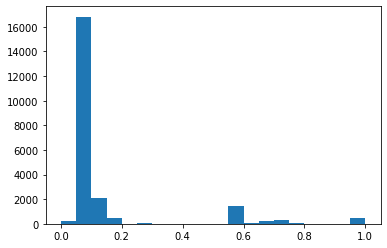

In [19]:
import matplotlib.pyplot as plt

Y_probs_train = label_model.predict_proba(train_L)
plt.hist(Y_probs_train[:, 1], bins=20, range=(0.0, 1.0))
plt.show()

### Part 4: Training our End Extraction Model

In this final section of the tutorial, we'll use our noisy training labels alongside the development set labels to train our end machine learning model. We start by filtering out training examples which did not recieve a label from any LF, as these examples contain no signal. Then we concatenate them with dev set examples.


In [20]:
from snorkel.analysis.utils import preds_to_probs
from snorkel.labeling.utils import filter_unlabeled_dataframe

# Change dev labels 1D array to 2D probabilities array as required for training end model.
Y_probs_dev = preds_to_probs(Y_dev, 2)

Y_probs_train = label_model.predict_proba(train_L)
df_train_filtered, Y_probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=Y_probs_train, L=train_L
)

df_combined = pd.concat([df_dev, df_train_filtered])
Y_probs_combined = np.concatenate([Y_probs_dev, Y_probs_train_filtered], 0)

### II. Training a _Long Short-term Memory_ (LSTM) Neural Network

[LSTMs](https://en.wikipedia.org/wiki/Long_short-term_memory) can acheive state-of-the-art performance on many text classification tasks. We'll train a simple LSTM model below. tf_model contains functions for processing features and building the tensorflow graphs for training and evaluation.

For this tutorial, we will be training a fairly effective deep learning model. More generally, however, Snorkel plugs in with many ML libraries, making it easy to use almost any state-of-the-art model as the end model!

In [21]:
from tf_model import get_model


# Truncate sentences to limit memory usage when padding.
def get_feature_arrays(df):
    def pad_or_truncate(l, max_length=40):
        return l[:max_length] + [""] * (max_length - len(l))

    tokens = np.array(list(map(pad_or_truncate, df.tokens)))
    idx1 = np.array(list(map(list, df.person1_word_idx)))
    idx2 = np.array(list(map(list, df.person2_word_idx)))
    return tokens, idx1, idx2


model = get_model()
tokens, idx1, idx2 = get_feature_arrays(df_combined)

batch_size = 64
num_epochs = 20  # TODO: Change this to ~50. Warning: Training takes several minutes!
model.fit(
    (tokens, idx1, idx2), Y_probs_combined, batch_size=batch_size, epochs=num_epochs
)

/home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/snorkel-t

/home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

W0806 19:43:54.086122 139836672341824 deprecation.py:506] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W0806 19:43:54.499981 139836672341824 deprecation.py:323] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:3794: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0806 19:43:54.538030 139836672341824 deprecation_wrapper.py:119] From /home/ubuntu/snorkel-tutorials/spouse/tf_model.py:41: The name tf.train.AdagradOptimizer is deprecated. Please use tf.compat.v1.train.AdagradOptimizer instead.



W0806 19:43:55.399769 139836672341824 deprecation.py:506] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/training/adagrad.py:76: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/20


  64/8545 [..............................] - ETA: 1:24 - loss: 0.6922

 192/8545 [..............................] - ETA: 30s - loss: 0.6563 

 320/8545 [>.............................] - ETA: 19s - loss: 0.6390

 448/8545 [>.............................] - ETA: 15s - loss: 0.6401

 576/8545 [=>............................] - ETA: 12s - loss: 0.6342

 704/8545 [=>............................] - ETA: 10s - loss: 0.6279

 832/8545 [=>............................] - ETA: 9s - loss: 0.6201 

 960/8545 [==>...........................] - ETA: 8s - loss: 0.6206

1088/8545 [==>...........................] - ETA: 8s - loss: 0.6205

1216/8545 [===>..........................] - ETA: 7s - loss: 0.6131

1344/8545 [===>..........................] - ETA: 7s - loss: 0.6057

1472/8545 [====>.........................] - ETA: 6s - loss: 0.6056

1600/8545 [====>.........................] - ETA: 6s - loss: 0.6036

1728/8545 [=====>........................] - ETA: 6s - loss: 0.6031

1856/8545 [=====>........................] - ETA: 5s - loss: 0.6006

1984/8545 [=====>........................] - ETA: 5s - loss: 0.5991

2112/8545 [======>.......................] - ETA: 5s - loss: 0.6003

2240/8545 [======>.......................] - ETA: 5s - loss: 0.5957

2368/8545 [=======>......................] - ETA: 4s - loss: 0.5941

2496/8545 [=======>......................] - ETA: 4s - loss: 0.5947

2624/8545 [========>.....................] - ETA: 4s - loss: 0.5943

2752/8545 [========>.....................] - ETA: 4s - loss: 0.5952

2880/8545 [=========>....................] - ETA: 4s - loss: 0.5949

3008/8545 [=========>....................] - ETA: 4s - loss: 0.5950

3136/8545 [==========>...................] - ETA: 3s - loss: 0.5935

3264/8545 [==========>...................] - ETA: 3s - loss: 0.5938

3392/8545 [==========>...................] - ETA: 3s - loss: 0.5936

3520/8545 [===========>..................] - ETA: 3s - loss: 0.5946

3648/8545 [===========>..................] - ETA: 3s - loss: 0.5953

3776/8545 [============>.................] - ETA: 3s - loss: 0.5956

3904/8545 [============>.................] - ETA: 3s - loss: 0.5952

4032/8545 [=============>................] - ETA: 3s - loss: 0.5949

4160/8545 [=============>................] - ETA: 3s - loss: 0.5940

4288/8545 [==============>...............] - ETA: 2s - loss: 0.5935

4416/8545 [==============>...............] - ETA: 2s - loss: 0.5932

4544/8545 [==============>...............] - ETA: 2s - loss: 0.5933

4672/8545 [===============>..............] - ETA: 2s - loss: 0.5922

4800/8545 [===============>..............] - ETA: 2s - loss: 0.5920

4928/8545 [================>.............] - ETA: 2s - loss: 0.5904

5056/8545 [================>.............] - ETA: 2s - loss: 0.5909

5184/8545 [=================>............] - ETA: 2s - loss: 0.5908

5312/8545 [=================>............] - ETA: 2s - loss: 0.5905

5440/8545 [==================>...........] - ETA: 2s - loss: 0.5909

5568/8545 [==================>...........] - ETA: 1s - loss: 0.5904

5696/8545 [==================>...........] - ETA: 1s - loss: 0.5892

5824/8545 [===================>..........] - ETA: 1s - loss: 0.5894

5952/8545 [===================>..........] - ETA: 1s - loss: 0.5895

6080/8545 [====================>.........] - ETA: 1s - loss: 0.5888

6208/8545 [====================>.........] - ETA: 1s - loss: 0.5889

6336/8545 [=====================>........] - ETA: 1s - loss: 0.5895

6464/8545 [=====================>........] - ETA: 1s - loss: 0.5889

6592/8545 [======================>.......] - ETA: 1s - loss: 0.5890

6720/8545 [======================>.......] - ETA: 1s - loss: 0.5889

6848/8545 [=======================>......] - ETA: 1s - loss: 0.5884

6976/8545 [=======================>......] - ETA: 0s - loss: 0.5894

7104/8545 [=======================>......] - ETA: 0s - loss: 0.5894

7232/8545 [========================>.....] - ETA: 0s - loss: 0.5889

7360/8545 [========================>.....] - ETA: 0s - loss: 0.5888

7488/8545 [=========================>....] - ETA: 0s - loss: 0.5888

7616/8545 [=========================>....] - ETA: 0s - loss: 0.5891

7744/8545 [==========================>...] - ETA: 0s - loss: 0.5884

7872/8545 [==========================>...] - ETA: 0s - loss: 0.5869

8000/8545 [===========================>..] - ETA: 0s - loss: 0.5875

8128/8545 [===========================>..] - ETA: 0s - loss: 0.5869

8256/8545 [===========================>..] - ETA: 0s - loss: 0.5866

8384/8545 [============================>.] - ETA: 0s - loss: 0.5859

8512/8545 [============================>.] - ETA: 0s - loss: 0.5857

8545/8545 [==============================] - 5s 619us/sample - loss: 0.5857


Epoch 2/20


  64/8545 [..............................] - ETA: 4s - loss: 0.5862

 192/8545 [..............................] - ETA: 4s - loss: 0.6195

 320/8545 [>.............................] - ETA: 4s - loss: 0.6006

 448/8545 [>.............................] - ETA: 4s - loss: 0.5864

 576/8545 [=>............................] - ETA: 4s - loss: 0.5883

 704/8545 [=>............................] - ETA: 4s - loss: 0.5876

 832/8545 [=>............................] - ETA: 4s - loss: 0.5891

 960/8545 [==>...........................] - ETA: 4s - loss: 0.5873

1088/8545 [==>...........................] - ETA: 4s - loss: 0.5877

1216/8545 [===>..........................] - ETA: 4s - loss: 0.5906

1344/8545 [===>..........................] - ETA: 3s - loss: 0.5888

1472/8545 [====>.........................] - ETA: 3s - loss: 0.5882

1600/8545 [====>.........................] - ETA: 3s - loss: 0.5888

1728/8545 [=====>........................] - ETA: 3s - loss: 0.5863

1856/8545 [=====>........................] - ETA: 3s - loss: 0.5845

1984/8545 [=====>........................] - ETA: 3s - loss: 0.5867

2112/8545 [======>.......................] - ETA: 3s - loss: 0.5839

2240/8545 [======>.......................] - ETA: 3s - loss: 0.5854

2368/8545 [=======>......................] - ETA: 3s - loss: 0.5877

2496/8545 [=======>......................] - ETA: 3s - loss: 0.5883

2624/8545 [========>.....................] - ETA: 3s - loss: 0.5887

2752/8545 [========>.....................] - ETA: 3s - loss: 0.5862

2880/8545 [=========>....................] - ETA: 3s - loss: 0.5843

3008/8545 [=========>....................] - ETA: 3s - loss: 0.5833

3136/8545 [==========>...................] - ETA: 2s - loss: 0.5838

3264/8545 [==========>...................] - ETA: 2s - loss: 0.5827

3392/8545 [==========>...................] - ETA: 2s - loss: 0.5823

3520/8545 [===========>..................] - ETA: 2s - loss: 0.5819

3648/8545 [===========>..................] - ETA: 2s - loss: 0.5814

3776/8545 [============>.................] - ETA: 2s - loss: 0.5827

3904/8545 [============>.................] - ETA: 2s - loss: 0.5816

4032/8545 [=============>................] - ETA: 2s - loss: 0.5811

4160/8545 [=============>................] - ETA: 2s - loss: 0.5812

4288/8545 [==============>...............] - ETA: 2s - loss: 0.5828

4416/8545 [==============>...............] - ETA: 2s - loss: 0.5825

4544/8545 [==============>...............] - ETA: 2s - loss: 0.5829

4672/8545 [===============>..............] - ETA: 2s - loss: 0.5837

4800/8545 [===============>..............] - ETA: 2s - loss: 0.5833

4928/8545 [================>.............] - ETA: 1s - loss: 0.5844

5056/8545 [================>.............] - ETA: 1s - loss: 0.5846

5184/8545 [=================>............] - ETA: 1s - loss: 0.5842

5312/8545 [=================>............] - ETA: 1s - loss: 0.5844

5440/8545 [==================>...........] - ETA: 1s - loss: 0.5833

5568/8545 [==================>...........] - ETA: 1s - loss: 0.5833

5696/8545 [==================>...........] - ETA: 1s - loss: 0.5835

5824/8545 [===================>..........] - ETA: 1s - loss: 0.5828

5952/8545 [===================>..........] - ETA: 1s - loss: 0.5825

6080/8545 [====================>.........] - ETA: 1s - loss: 0.5831

6208/8545 [====================>.........] - ETA: 1s - loss: 0.5838

6336/8545 [=====================>........] - ETA: 1s - loss: 0.5840

6464/8545 [=====================>........] - ETA: 1s - loss: 0.5845

6592/8545 [======================>.......] - ETA: 1s - loss: 0.5837

6720/8545 [======================>.......] - ETA: 1s - loss: 0.5836

6848/8545 [=======================>......] - ETA: 0s - loss: 0.5839

6976/8545 [=======================>......] - ETA: 0s - loss: 0.5843

7104/8545 [=======================>......] - ETA: 0s - loss: 0.5853

7232/8545 [========================>.....] - ETA: 0s - loss: 0.5853

7360/8545 [========================>.....] - ETA: 0s - loss: 0.5849

7488/8545 [=========================>....] - ETA: 0s - loss: 0.5844

7616/8545 [=========================>....] - ETA: 0s - loss: 0.5854

7744/8545 [==========================>...] - ETA: 0s - loss: 0.5848

7872/8545 [==========================>...] - ETA: 0s - loss: 0.5858

8000/8545 [===========================>..] - ETA: 0s - loss: 0.5855

8128/8545 [===========================>..] - ETA: 0s - loss: 0.5844

8256/8545 [===========================>..] - ETA: 0s - loss: 0.5846

8384/8545 [============================>.] - ETA: 0s - loss: 0.5838

8512/8545 [============================>.] - ETA: 0s - loss: 0.5835

8545/8545 [==============================] - 5s 551us/sample - loss: 0.5834


Epoch 3/20


  64/8545 [..............................] - ETA: 4s - loss: 0.5777

 192/8545 [..............................] - ETA: 4s - loss: 0.5437

 320/8545 [>.............................] - ETA: 4s - loss: 0.5703

 448/8545 [>.............................] - ETA: 4s - loss: 0.5700

 576/8545 [=>............................] - ETA: 4s - loss: 0.5872

 704/8545 [=>............................] - ETA: 4s - loss: 0.5820

 832/8545 [=>............................] - ETA: 4s - loss: 0.5866

 960/8545 [==>...........................] - ETA: 4s - loss: 0.5818

1088/8545 [==>...........................] - ETA: 4s - loss: 0.5819

1216/8545 [===>..........................] - ETA: 4s - loss: 0.5821

1344/8545 [===>..........................] - ETA: 3s - loss: 0.5863

1472/8545 [====>.........................] - ETA: 3s - loss: 0.5850

1600/8545 [====>.........................] - ETA: 3s - loss: 0.5854

1728/8545 [=====>........................] - ETA: 3s - loss: 0.5855

1856/8545 [=====>........................] - ETA: 3s - loss: 0.5851

1984/8545 [=====>........................] - ETA: 3s - loss: 0.5845

2112/8545 [======>.......................] - ETA: 3s - loss: 0.5861

2240/8545 [======>.......................] - ETA: 3s - loss: 0.5854

2368/8545 [=======>......................] - ETA: 3s - loss: 0.5874

2496/8545 [=======>......................] - ETA: 3s - loss: 0.5851

2624/8545 [========>.....................] - ETA: 3s - loss: 0.5837

2752/8545 [========>.....................] - ETA: 3s - loss: 0.5871

2880/8545 [=========>....................] - ETA: 3s - loss: 0.5871

3008/8545 [=========>....................] - ETA: 3s - loss: 0.5886

3136/8545 [==========>...................] - ETA: 2s - loss: 0.5897

3264/8545 [==========>...................] - ETA: 2s - loss: 0.5881

3392/8545 [==========>...................] - ETA: 2s - loss: 0.5878

3520/8545 [===========>..................] - ETA: 2s - loss: 0.5887

3648/8545 [===========>..................] - ETA: 2s - loss: 0.5897

3776/8545 [============>.................] - ETA: 2s - loss: 0.5872

3904/8545 [============>.................] - ETA: 2s - loss: 0.5881

4032/8545 [=============>................] - ETA: 2s - loss: 0.5878

4160/8545 [=============>................] - ETA: 2s - loss: 0.5862

4288/8545 [==============>...............] - ETA: 2s - loss: 0.5863

4416/8545 [==============>...............] - ETA: 2s - loss: 0.5860

4544/8545 [==============>...............] - ETA: 2s - loss: 0.5865

4672/8545 [===============>..............] - ETA: 2s - loss: 0.5862

4800/8545 [===============>..............] - ETA: 2s - loss: 0.5870

4928/8545 [================>.............] - ETA: 1s - loss: 0.5871

5056/8545 [================>.............] - ETA: 1s - loss: 0.5877

5184/8545 [=================>............] - ETA: 1s - loss: 0.5882

5312/8545 [=================>............] - ETA: 1s - loss: 0.5882

5440/8545 [==================>...........] - ETA: 1s - loss: 0.5877

5568/8545 [==================>...........] - ETA: 1s - loss: 0.5886

5696/8545 [==================>...........] - ETA: 1s - loss: 0.5880

5824/8545 [===================>..........] - ETA: 1s - loss: 0.5873

5952/8545 [===================>..........] - ETA: 1s - loss: 0.5875

6080/8545 [====================>.........] - ETA: 1s - loss: 0.5870

6208/8545 [====================>.........] - ETA: 1s - loss: 0.5863

6336/8545 [=====================>........] - ETA: 1s - loss: 0.5863

6464/8545 [=====================>........] - ETA: 1s - loss: 0.5862

6592/8545 [======================>.......] - ETA: 1s - loss: 0.5857

6720/8545 [======================>.......] - ETA: 0s - loss: 0.5854

6848/8545 [=======================>......] - ETA: 0s - loss: 0.5855

6976/8545 [=======================>......] - ETA: 0s - loss: 0.5853

7104/8545 [=======================>......] - ETA: 0s - loss: 0.5848

7232/8545 [========================>.....] - ETA: 0s - loss: 0.5848

7360/8545 [========================>.....] - ETA: 0s - loss: 0.5850

7488/8545 [=========================>....] - ETA: 0s - loss: 0.5854

7616/8545 [=========================>....] - ETA: 0s - loss: 0.5851

7744/8545 [==========================>...] - ETA: 0s - loss: 0.5845

7872/8545 [==========================>...] - ETA: 0s - loss: 0.5840

8000/8545 [===========================>..] - ETA: 0s - loss: 0.5830

8128/8545 [===========================>..] - ETA: 0s - loss: 0.5833

8256/8545 [===========================>..] - ETA: 0s - loss: 0.5830

8384/8545 [============================>.] - ETA: 0s - loss: 0.5829

8512/8545 [============================>.] - ETA: 0s - loss: 0.5825

8545/8545 [==============================] - 5s 548us/sample - loss: 0.5828


Epoch 4/20


  64/8545 [..............................] - ETA: 4s - loss: 0.5642

 192/8545 [..............................] - ETA: 4s - loss: 0.5549

 320/8545 [>.............................] - ETA: 4s - loss: 0.5769

 448/8545 [>.............................] - ETA: 4s - loss: 0.5672

 576/8545 [=>............................] - ETA: 4s - loss: 0.5630

 704/8545 [=>............................] - ETA: 4s - loss: 0.5750

 832/8545 [=>............................] - ETA: 4s - loss: 0.5767

 960/8545 [==>...........................] - ETA: 4s - loss: 0.5803

1088/8545 [==>...........................] - ETA: 4s - loss: 0.5764

1216/8545 [===>..........................] - ETA: 4s - loss: 0.5779

1344/8545 [===>..........................] - ETA: 3s - loss: 0.5754

1472/8545 [====>.........................] - ETA: 3s - loss: 0.5789

1600/8545 [====>.........................] - ETA: 3s - loss: 0.5794

1728/8545 [=====>........................] - ETA: 3s - loss: 0.5774

1856/8545 [=====>........................] - ETA: 3s - loss: 0.5784

1984/8545 [=====>........................] - ETA: 3s - loss: 0.5785

2112/8545 [======>.......................] - ETA: 3s - loss: 0.5795

2240/8545 [======>.......................] - ETA: 3s - loss: 0.5792

2368/8545 [=======>......................] - ETA: 3s - loss: 0.5824

2496/8545 [=======>......................] - ETA: 3s - loss: 0.5831

2624/8545 [========>.....................] - ETA: 3s - loss: 0.5838

2752/8545 [========>.....................] - ETA: 3s - loss: 0.5837

2880/8545 [=========>....................] - ETA: 3s - loss: 0.5812

3008/8545 [=========>....................] - ETA: 3s - loss: 0.5818

3136/8545 [==========>...................] - ETA: 2s - loss: 0.5809

3264/8545 [==========>...................] - ETA: 2s - loss: 0.5806

3392/8545 [==========>...................] - ETA: 2s - loss: 0.5829

3520/8545 [===========>..................] - ETA: 2s - loss: 0.5822

3648/8545 [===========>..................] - ETA: 2s - loss: 0.5821

3776/8545 [============>.................] - ETA: 2s - loss: 0.5820

3904/8545 [============>.................] - ETA: 2s - loss: 0.5813

4032/8545 [=============>................] - ETA: 2s - loss: 0.5815

4160/8545 [=============>................] - ETA: 2s - loss: 0.5818

4288/8545 [==============>...............] - ETA: 2s - loss: 0.5819

4416/8545 [==============>...............] - ETA: 2s - loss: 0.5822

4544/8545 [==============>...............] - ETA: 2s - loss: 0.5826

4672/8545 [===============>..............] - ETA: 2s - loss: 0.5828

4800/8545 [===============>..............] - ETA: 2s - loss: 0.5828

4928/8545 [================>.............] - ETA: 1s - loss: 0.5825

5056/8545 [================>.............] - ETA: 1s - loss: 0.5826

5184/8545 [=================>............] - ETA: 1s - loss: 0.5828

5312/8545 [=================>............] - ETA: 1s - loss: 0.5827

5440/8545 [==================>...........] - ETA: 1s - loss: 0.5842

5568/8545 [==================>...........] - ETA: 1s - loss: 0.5840

5696/8545 [==================>...........] - ETA: 1s - loss: 0.5822

5824/8545 [===================>..........] - ETA: 1s - loss: 0.5825

5952/8545 [===================>..........] - ETA: 1s - loss: 0.5824

6080/8545 [====================>.........] - ETA: 1s - loss: 0.5822

6208/8545 [====================>.........] - ETA: 1s - loss: 0.5832

6336/8545 [=====================>........] - ETA: 1s - loss: 0.5817

6464/8545 [=====================>........] - ETA: 1s - loss: 0.5809

6592/8545 [======================>.......] - ETA: 1s - loss: 0.5806

6720/8545 [======================>.......] - ETA: 1s - loss: 0.5801

6848/8545 [=======================>......] - ETA: 0s - loss: 0.5809

6976/8545 [=======================>......] - ETA: 0s - loss: 0.5821

7104/8545 [=======================>......] - ETA: 0s - loss: 0.5815

7232/8545 [========================>.....] - ETA: 0s - loss: 0.5817

7360/8545 [========================>.....] - ETA: 0s - loss: 0.5820

7488/8545 [=========================>....] - ETA: 0s - loss: 0.5820

7616/8545 [=========================>....] - ETA: 0s - loss: 0.5817

7744/8545 [==========================>...] - ETA: 0s - loss: 0.5814

7872/8545 [==========================>...] - ETA: 0s - loss: 0.5818

8000/8545 [===========================>..] - ETA: 0s - loss: 0.5813

8128/8545 [===========================>..] - ETA: 0s - loss: 0.5815

8256/8545 [===========================>..] - ETA: 0s - loss: 0.5820

8384/8545 [============================>.] - ETA: 0s - loss: 0.5820

8512/8545 [============================>.] - ETA: 0s - loss: 0.5818

8545/8545 [==============================] - 5s 551us/sample - loss: 0.5822


Epoch 5/20


  64/8545 [..............................] - ETA: 4s - loss: 0.5412

 192/8545 [..............................] - ETA: 4s - loss: 0.5721

 320/8545 [>.............................] - ETA: 4s - loss: 0.5740

 448/8545 [>.............................] - ETA: 4s - loss: 0.5754

 576/8545 [=>............................] - ETA: 4s - loss: 0.5645

 704/8545 [=>............................] - ETA: 4s - loss: 0.5670

 832/8545 [=>............................] - ETA: 4s - loss: 0.5714

 960/8545 [==>...........................] - ETA: 4s - loss: 0.5704

1088/8545 [==>...........................] - ETA: 4s - loss: 0.5725

1216/8545 [===>..........................] - ETA: 4s - loss: 0.5764

1344/8545 [===>..........................] - ETA: 3s - loss: 0.5764

1472/8545 [====>.........................] - ETA: 3s - loss: 0.5769

1600/8545 [====>.........................] - ETA: 3s - loss: 0.5811

1728/8545 [=====>........................] - ETA: 3s - loss: 0.5790

1856/8545 [=====>........................] - ETA: 3s - loss: 0.5804

1984/8545 [=====>........................] - ETA: 3s - loss: 0.5820

2112/8545 [======>.......................] - ETA: 3s - loss: 0.5812

2240/8545 [======>.......................] - ETA: 3s - loss: 0.5790

2368/8545 [=======>......................] - ETA: 3s - loss: 0.5793

2496/8545 [=======>......................] - ETA: 3s - loss: 0.5764

2624/8545 [========>.....................] - ETA: 3s - loss: 0.5757

2752/8545 [========>.....................] - ETA: 3s - loss: 0.5754

2880/8545 [=========>....................] - ETA: 3s - loss: 0.5737

3008/8545 [=========>....................] - ETA: 3s - loss: 0.5778

3136/8545 [==========>...................] - ETA: 2s - loss: 0.5794

3264/8545 [==========>...................] - ETA: 2s - loss: 0.5792

3392/8545 [==========>...................] - ETA: 2s - loss: 0.5791

3520/8545 [===========>..................] - ETA: 2s - loss: 0.5790

3648/8545 [===========>..................] - ETA: 2s - loss: 0.5781

3776/8545 [============>.................] - ETA: 2s - loss: 0.5778

3904/8545 [============>.................] - ETA: 2s - loss: 0.5782

4032/8545 [=============>................] - ETA: 2s - loss: 0.5778

4160/8545 [=============>................] - ETA: 2s - loss: 0.5766

4288/8545 [==============>...............] - ETA: 2s - loss: 0.5770

4416/8545 [==============>...............] - ETA: 2s - loss: 0.5752

4544/8545 [==============>...............] - ETA: 2s - loss: 0.5755

4672/8545 [===============>..............] - ETA: 2s - loss: 0.5753

4800/8545 [===============>..............] - ETA: 2s - loss: 0.5775

4928/8545 [================>.............] - ETA: 1s - loss: 0.5766

5056/8545 [================>.............] - ETA: 1s - loss: 0.5772

5184/8545 [=================>............] - ETA: 1s - loss: 0.5782

5312/8545 [=================>............] - ETA: 1s - loss: 0.5782

5440/8545 [==================>...........] - ETA: 1s - loss: 0.5779

5568/8545 [==================>...........] - ETA: 1s - loss: 0.5780

5696/8545 [==================>...........] - ETA: 1s - loss: 0.5781

5824/8545 [===================>..........] - ETA: 1s - loss: 0.5788

5952/8545 [===================>..........] - ETA: 1s - loss: 0.5785

6080/8545 [====================>.........] - ETA: 1s - loss: 0.5780

6208/8545 [====================>.........] - ETA: 1s - loss: 0.5775

6336/8545 [=====================>........] - ETA: 1s - loss: 0.5778

6464/8545 [=====================>........] - ETA: 1s - loss: 0.5793

6592/8545 [======================>.......] - ETA: 1s - loss: 0.5793

6720/8545 [======================>.......] - ETA: 1s - loss: 0.5788

6848/8545 [=======================>......] - ETA: 0s - loss: 0.5796

6976/8545 [=======================>......] - ETA: 0s - loss: 0.5801

7104/8545 [=======================>......] - ETA: 0s - loss: 0.5804

7232/8545 [========================>.....] - ETA: 0s - loss: 0.5808

7360/8545 [========================>.....] - ETA: 0s - loss: 0.5813

7488/8545 [=========================>....] - ETA: 0s - loss: 0.5817

7616/8545 [=========================>....] - ETA: 0s - loss: 0.5824

7744/8545 [==========================>...] - ETA: 0s - loss: 0.5828

7872/8545 [==========================>...] - ETA: 0s - loss: 0.5825

8000/8545 [===========================>..] - ETA: 0s - loss: 0.5826

8128/8545 [===========================>..] - ETA: 0s - loss: 0.5823

8256/8545 [===========================>..] - ETA: 0s - loss: 0.5822

8384/8545 [============================>.] - ETA: 0s - loss: 0.5819

8512/8545 [============================>.] - ETA: 0s - loss: 0.5813

8545/8545 [==============================] - 5s 551us/sample - loss: 0.5808


Epoch 6/20


  64/8545 [..............................] - ETA: 4s - loss: 0.6557

 192/8545 [..............................] - ETA: 4s - loss: 0.6176

 320/8545 [>.............................] - ETA: 4s - loss: 0.6004

 448/8545 [>.............................] - ETA: 4s - loss: 0.5828

 576/8545 [=>............................] - ETA: 4s - loss: 0.5929

 704/8545 [=>............................] - ETA: 4s - loss: 0.5852

 832/8545 [=>............................] - ETA: 4s - loss: 0.5910

 960/8545 [==>...........................] - ETA: 4s - loss: 0.5858

1088/8545 [==>...........................] - ETA: 4s - loss: 0.5858

1216/8545 [===>..........................] - ETA: 3s - loss: 0.5856

1344/8545 [===>..........................] - ETA: 3s - loss: 0.5856

1472/8545 [====>.........................] - ETA: 3s - loss: 0.5840

1600/8545 [====>.........................] - ETA: 3s - loss: 0.5855

1728/8545 [=====>........................] - ETA: 3s - loss: 0.5863

1856/8545 [=====>........................] - ETA: 3s - loss: 0.5871

1984/8545 [=====>........................] - ETA: 3s - loss: 0.5848

2112/8545 [======>.......................] - ETA: 3s - loss: 0.5857

2240/8545 [======>.......................] - ETA: 3s - loss: 0.5860

2368/8545 [=======>......................] - ETA: 3s - loss: 0.5871

2496/8545 [=======>......................] - ETA: 3s - loss: 0.5851

2624/8545 [========>.....................] - ETA: 3s - loss: 0.5833

2752/8545 [========>.....................] - ETA: 3s - loss: 0.5820

2880/8545 [=========>....................] - ETA: 3s - loss: 0.5823

3008/8545 [=========>....................] - ETA: 3s - loss: 0.5816

3136/8545 [==========>...................] - ETA: 2s - loss: 0.5847

3264/8545 [==========>...................] - ETA: 2s - loss: 0.5839

3392/8545 [==========>...................] - ETA: 2s - loss: 0.5831

3520/8545 [===========>..................] - ETA: 2s - loss: 0.5823

3648/8545 [===========>..................] - ETA: 2s - loss: 0.5820

3776/8545 [============>.................] - ETA: 2s - loss: 0.5797

3904/8545 [============>.................] - ETA: 2s - loss: 0.5782

4032/8545 [=============>................] - ETA: 2s - loss: 0.5793

4160/8545 [=============>................] - ETA: 2s - loss: 0.5786

4288/8545 [==============>...............] - ETA: 2s - loss: 0.5789

4416/8545 [==============>...............] - ETA: 2s - loss: 0.5792

4544/8545 [==============>...............] - ETA: 2s - loss: 0.5792

4672/8545 [===============>..............] - ETA: 2s - loss: 0.5794

4800/8545 [===============>..............] - ETA: 2s - loss: 0.5793

4928/8545 [================>.............] - ETA: 1s - loss: 0.5800

5056/8545 [================>.............] - ETA: 1s - loss: 0.5798

5184/8545 [=================>............] - ETA: 1s - loss: 0.5794

5312/8545 [=================>............] - ETA: 1s - loss: 0.5795

5440/8545 [==================>...........] - ETA: 1s - loss: 0.5801

5568/8545 [==================>...........] - ETA: 1s - loss: 0.5798

5696/8545 [==================>...........] - ETA: 1s - loss: 0.5783

5824/8545 [===================>..........] - ETA: 1s - loss: 0.5801

5952/8545 [===================>..........] - ETA: 1s - loss: 0.5797

6080/8545 [====================>.........] - ETA: 1s - loss: 0.5800

6208/8545 [====================>.........] - ETA: 1s - loss: 0.5799

6336/8545 [=====================>........] - ETA: 1s - loss: 0.5798

6464/8545 [=====================>........] - ETA: 1s - loss: 0.5796

6592/8545 [======================>.......] - ETA: 1s - loss: 0.5808

6720/8545 [======================>.......] - ETA: 1s - loss: 0.5812

6848/8545 [=======================>......] - ETA: 0s - loss: 0.5813

6976/8545 [=======================>......] - ETA: 0s - loss: 0.5811

7104/8545 [=======================>......] - ETA: 0s - loss: 0.5815

7232/8545 [========================>.....] - ETA: 0s - loss: 0.5817

7360/8545 [========================>.....] - ETA: 0s - loss: 0.5816

7488/8545 [=========================>....] - ETA: 0s - loss: 0.5813

7616/8545 [=========================>....] - ETA: 0s - loss: 0.5814

7744/8545 [==========================>...] - ETA: 0s - loss: 0.5811

7872/8545 [==========================>...] - ETA: 0s - loss: 0.5808

8000/8545 [===========================>..] - ETA: 0s - loss: 0.5805

8128/8545 [===========================>..] - ETA: 0s - loss: 0.5809

8256/8545 [===========================>..] - ETA: 0s - loss: 0.5807

8384/8545 [============================>.] - ETA: 0s - loss: 0.5804

8512/8545 [============================>.] - ETA: 0s - loss: 0.5795

8545/8545 [==============================] - 5s 550us/sample - loss: 0.5792


Epoch 7/20


  64/8545 [..............................] - ETA: 4s - loss: 0.5505

 192/8545 [..............................] - ETA: 4s - loss: 0.5642

 320/8545 [>.............................] - ETA: 4s - loss: 0.5845

 448/8545 [>.............................] - ETA: 4s - loss: 0.5840

 576/8545 [=>............................] - ETA: 4s - loss: 0.5796

 704/8545 [=>............................] - ETA: 4s - loss: 0.5841

 832/8545 [=>............................] - ETA: 4s - loss: 0.5809

 960/8545 [==>...........................] - ETA: 4s - loss: 0.5827

1088/8545 [==>...........................] - ETA: 4s - loss: 0.5844

1216/8545 [===>..........................] - ETA: 4s - loss: 0.5791

1344/8545 [===>..........................] - ETA: 3s - loss: 0.5819

1472/8545 [====>.........................] - ETA: 3s - loss: 0.5818

1600/8545 [====>.........................] - ETA: 3s - loss: 0.5873

1728/8545 [=====>........................] - ETA: 3s - loss: 0.5875

1856/8545 [=====>........................] - ETA: 3s - loss: 0.5897

1984/8545 [=====>........................] - ETA: 3s - loss: 0.5872

2112/8545 [======>.......................] - ETA: 3s - loss: 0.5861

2240/8545 [======>.......................] - ETA: 3s - loss: 0.5857

2368/8545 [=======>......................] - ETA: 3s - loss: 0.5849

2496/8545 [=======>......................] - ETA: 3s - loss: 0.5839

2624/8545 [========>.....................] - ETA: 3s - loss: 0.5834

2752/8545 [========>.....................] - ETA: 3s - loss: 0.5821

2880/8545 [=========>....................] - ETA: 3s - loss: 0.5834

3008/8545 [=========>....................] - ETA: 3s - loss: 0.5829

3136/8545 [==========>...................] - ETA: 2s - loss: 0.5830

3264/8545 [==========>...................] - ETA: 2s - loss: 0.5814

3392/8545 [==========>...................] - ETA: 2s - loss: 0.5821

3520/8545 [===========>..................] - ETA: 2s - loss: 0.5817

3648/8545 [===========>..................] - ETA: 2s - loss: 0.5790

3776/8545 [============>.................] - ETA: 2s - loss: 0.5788

3904/8545 [============>.................] - ETA: 2s - loss: 0.5784

4032/8545 [=============>................] - ETA: 2s - loss: 0.5795

4160/8545 [=============>................] - ETA: 2s - loss: 0.5798

4288/8545 [==============>...............] - ETA: 2s - loss: 0.5797

4416/8545 [==============>...............] - ETA: 2s - loss: 0.5803

4544/8545 [==============>...............] - ETA: 2s - loss: 0.5800

4672/8545 [===============>..............] - ETA: 2s - loss: 0.5800

4800/8545 [===============>..............] - ETA: 2s - loss: 0.5787

4928/8545 [================>.............] - ETA: 1s - loss: 0.5800

5056/8545 [================>.............] - ETA: 1s - loss: 0.5797

5184/8545 [=================>............] - ETA: 1s - loss: 0.5798

5312/8545 [=================>............] - ETA: 1s - loss: 0.5797

5440/8545 [==================>...........] - ETA: 1s - loss: 0.5791

5568/8545 [==================>...........] - ETA: 1s - loss: 0.5779

5696/8545 [==================>...........] - ETA: 1s - loss: 0.5770

5824/8545 [===================>..........] - ETA: 1s - loss: 0.5773

5952/8545 [===================>..........] - ETA: 1s - loss: 0.5766

6080/8545 [====================>.........] - ETA: 1s - loss: 0.5760

6208/8545 [====================>.........] - ETA: 1s - loss: 0.5768

6336/8545 [=====================>........] - ETA: 1s - loss: 0.5771

6464/8545 [=====================>........] - ETA: 1s - loss: 0.5770

6592/8545 [======================>.......] - ETA: 1s - loss: 0.5762

6720/8545 [======================>.......] - ETA: 1s - loss: 0.5764

6848/8545 [=======================>......] - ETA: 0s - loss: 0.5767

6976/8545 [=======================>......] - ETA: 0s - loss: 0.5765

7104/8545 [=======================>......] - ETA: 0s - loss: 0.5766

7232/8545 [========================>.....] - ETA: 0s - loss: 0.5774

7360/8545 [========================>.....] - ETA: 0s - loss: 0.5772

7488/8545 [=========================>....] - ETA: 0s - loss: 0.5757

7616/8545 [=========================>....] - ETA: 0s - loss: 0.5755

7744/8545 [==========================>...] - ETA: 0s - loss: 0.5752

7872/8545 [==========================>...] - ETA: 0s - loss: 0.5752

8000/8545 [===========================>..] - ETA: 0s - loss: 0.5752

8128/8545 [===========================>..] - ETA: 0s - loss: 0.5754

8256/8545 [===========================>..] - ETA: 0s - loss: 0.5748

8384/8545 [============================>.] - ETA: 0s - loss: 0.5752

8512/8545 [============================>.] - ETA: 0s - loss: 0.5748

8545/8545 [==============================] - 5s 551us/sample - loss: 0.5746


Epoch 8/20


  64/8545 [..............................] - ETA: 4s - loss: 0.5046

 192/8545 [..............................] - ETA: 4s - loss: 0.5522

 320/8545 [>.............................] - ETA: 4s - loss: 0.5641

 448/8545 [>.............................] - ETA: 4s - loss: 0.5670

 576/8545 [=>............................] - ETA: 4s - loss: 0.5630

 704/8545 [=>............................] - ETA: 4s - loss: 0.5653

 832/8545 [=>............................] - ETA: 4s - loss: 0.5680

 960/8545 [==>...........................] - ETA: 4s - loss: 0.5753

1088/8545 [==>...........................] - ETA: 4s - loss: 0.5736

1216/8545 [===>..........................] - ETA: 4s - loss: 0.5726

1344/8545 [===>..........................] - ETA: 3s - loss: 0.5761

1472/8545 [====>.........................] - ETA: 3s - loss: 0.5742

1600/8545 [====>.........................] - ETA: 3s - loss: 0.5749

1728/8545 [=====>........................] - ETA: 3s - loss: 0.5756

1856/8545 [=====>........................] - ETA: 3s - loss: 0.5777

1984/8545 [=====>........................] - ETA: 3s - loss: 0.5786

2112/8545 [======>.......................] - ETA: 3s - loss: 0.5795

2240/8545 [======>.......................] - ETA: 3s - loss: 0.5816

2368/8545 [=======>......................] - ETA: 3s - loss: 0.5817

2496/8545 [=======>......................] - ETA: 3s - loss: 0.5814

2624/8545 [========>.....................] - ETA: 3s - loss: 0.5785

2752/8545 [========>.....................] - ETA: 3s - loss: 0.5783

2880/8545 [=========>....................] - ETA: 3s - loss: 0.5751

3008/8545 [=========>....................] - ETA: 3s - loss: 0.5749

3136/8545 [==========>...................] - ETA: 2s - loss: 0.5751

3264/8545 [==========>...................] - ETA: 2s - loss: 0.5738

3392/8545 [==========>...................] - ETA: 2s - loss: 0.5731

3520/8545 [===========>..................] - ETA: 2s - loss: 0.5712

3648/8545 [===========>..................] - ETA: 2s - loss: 0.5710

3776/8545 [============>.................] - ETA: 2s - loss: 0.5696

3904/8545 [============>.................] - ETA: 2s - loss: 0.5730

4032/8545 [=============>................] - ETA: 2s - loss: 0.5731

4160/8545 [=============>................] - ETA: 2s - loss: 0.5733

4288/8545 [==============>...............] - ETA: 2s - loss: 0.5730

4416/8545 [==============>...............] - ETA: 2s - loss: 0.5722

4544/8545 [==============>...............] - ETA: 2s - loss: 0.5716

4672/8545 [===============>..............] - ETA: 2s - loss: 0.5708

4800/8545 [===============>..............] - ETA: 2s - loss: 0.5694

4928/8545 [================>.............] - ETA: 1s - loss: 0.5694

5056/8545 [================>.............] - ETA: 1s - loss: 0.5698

5184/8545 [=================>............] - ETA: 1s - loss: 0.5690

5312/8545 [=================>............] - ETA: 1s - loss: 0.5689

5440/8545 [==================>...........] - ETA: 1s - loss: 0.5686

5568/8545 [==================>...........] - ETA: 1s - loss: 0.5679

5696/8545 [==================>...........] - ETA: 1s - loss: 0.5676

5824/8545 [===================>..........] - ETA: 1s - loss: 0.5677

5952/8545 [===================>..........] - ETA: 1s - loss: 0.5688

6080/8545 [====================>.........] - ETA: 1s - loss: 0.5691

6208/8545 [====================>.........] - ETA: 1s - loss: 0.5689

6336/8545 [=====================>........] - ETA: 1s - loss: 0.5688

6464/8545 [=====================>........] - ETA: 1s - loss: 0.5687

6592/8545 [======================>.......] - ETA: 1s - loss: 0.5689

6720/8545 [======================>.......] - ETA: 1s - loss: 0.5695

6848/8545 [=======================>......] - ETA: 0s - loss: 0.5696

6976/8545 [=======================>......] - ETA: 0s - loss: 0.5688

7104/8545 [=======================>......] - ETA: 0s - loss: 0.5700

7232/8545 [========================>.....] - ETA: 0s - loss: 0.5696

7360/8545 [========================>.....] - ETA: 0s - loss: 0.5691

7488/8545 [=========================>....] - ETA: 0s - loss: 0.5690

7616/8545 [=========================>....] - ETA: 0s - loss: 0.5702

7744/8545 [==========================>...] - ETA: 0s - loss: 0.5693

7872/8545 [==========================>...] - ETA: 0s - loss: 0.5686

8000/8545 [===========================>..] - ETA: 0s - loss: 0.5685

8128/8545 [===========================>..] - ETA: 0s - loss: 0.5683

8256/8545 [===========================>..] - ETA: 0s - loss: 0.5674

8384/8545 [============================>.] - ETA: 0s - loss: 0.5679

8512/8545 [============================>.] - ETA: 0s - loss: 0.5678

8545/8545 [==============================] - 5s 552us/sample - loss: 0.5677


Epoch 9/20


  64/8545 [..............................] - ETA: 4s - loss: 0.6568

 192/8545 [..............................] - ETA: 4s - loss: 0.6013

 320/8545 [>.............................] - ETA: 4s - loss: 0.5630

 448/8545 [>.............................] - ETA: 4s - loss: 0.5509

 576/8545 [=>............................] - ETA: 4s - loss: 0.5661

 704/8545 [=>............................] - ETA: 4s - loss: 0.5704

 832/8545 [=>............................] - ETA: 4s - loss: 0.5710

 960/8545 [==>...........................] - ETA: 4s - loss: 0.5693

1088/8545 [==>...........................] - ETA: 4s - loss: 0.5665

1216/8545 [===>..........................] - ETA: 3s - loss: 0.5685

1344/8545 [===>..........................] - ETA: 3s - loss: 0.5641

1472/8545 [====>.........................] - ETA: 3s - loss: 0.5655

1600/8545 [====>.........................] - ETA: 3s - loss: 0.5679

1728/8545 [=====>........................] - ETA: 3s - loss: 0.5653

1856/8545 [=====>........................] - ETA: 3s - loss: 0.5631

1984/8545 [=====>........................] - ETA: 3s - loss: 0.5628

2112/8545 [======>.......................] - ETA: 3s - loss: 0.5601

2240/8545 [======>.......................] - ETA: 3s - loss: 0.5569

2368/8545 [=======>......................] - ETA: 3s - loss: 0.5600

2496/8545 [=======>......................] - ETA: 3s - loss: 0.5600

2624/8545 [========>.....................] - ETA: 3s - loss: 0.5586

2752/8545 [========>.....................] - ETA: 3s - loss: 0.5561

2880/8545 [=========>....................] - ETA: 3s - loss: 0.5566

3008/8545 [=========>....................] - ETA: 3s - loss: 0.5562

3136/8545 [==========>...................] - ETA: 2s - loss: 0.5564

3264/8545 [==========>...................] - ETA: 2s - loss: 0.5555

3392/8545 [==========>...................] - ETA: 2s - loss: 0.5563

3520/8545 [===========>..................] - ETA: 2s - loss: 0.5581

3648/8545 [===========>..................] - ETA: 2s - loss: 0.5594

3776/8545 [============>.................] - ETA: 2s - loss: 0.5586

3904/8545 [============>.................] - ETA: 2s - loss: 0.5574

4032/8545 [=============>................] - ETA: 2s - loss: 0.5578

4160/8545 [=============>................] - ETA: 2s - loss: 0.5567

4288/8545 [==============>...............] - ETA: 2s - loss: 0.5558

4416/8545 [==============>...............] - ETA: 2s - loss: 0.5550

4544/8545 [==============>...............] - ETA: 2s - loss: 0.5560

4672/8545 [===============>..............] - ETA: 2s - loss: 0.5556

4800/8545 [===============>..............] - ETA: 2s - loss: 0.5572

4928/8545 [================>.............] - ETA: 1s - loss: 0.5567

5056/8545 [================>.............] - ETA: 1s - loss: 0.5575

5184/8545 [=================>............] - ETA: 1s - loss: 0.5577

5312/8545 [=================>............] - ETA: 1s - loss: 0.5569

5440/8545 [==================>...........] - ETA: 1s - loss: 0.5580

5568/8545 [==================>...........] - ETA: 1s - loss: 0.5573

5696/8545 [==================>...........] - ETA: 1s - loss: 0.5574

5824/8545 [===================>..........] - ETA: 1s - loss: 0.5560

5952/8545 [===================>..........] - ETA: 1s - loss: 0.5550

6080/8545 [====================>.........] - ETA: 1s - loss: 0.5532

6208/8545 [====================>.........] - ETA: 1s - loss: 0.5534

6336/8545 [=====================>........] - ETA: 1s - loss: 0.5528

6464/8545 [=====================>........] - ETA: 1s - loss: 0.5511

6592/8545 [======================>.......] - ETA: 1s - loss: 0.5503

6720/8545 [======================>.......] - ETA: 1s - loss: 0.5507

6848/8545 [=======================>......] - ETA: 0s - loss: 0.5520

6976/8545 [=======================>......] - ETA: 0s - loss: 0.5523

7104/8545 [=======================>......] - ETA: 0s - loss: 0.5517

7232/8545 [========================>.....] - ETA: 0s - loss: 0.5509

7360/8545 [========================>.....] - ETA: 0s - loss: 0.5493

7488/8545 [=========================>....] - ETA: 0s - loss: 0.5491

7616/8545 [=========================>....] - ETA: 0s - loss: 0.5486

7744/8545 [==========================>...] - ETA: 0s - loss: 0.5484

7872/8545 [==========================>...] - ETA: 0s - loss: 0.5498

8000/8545 [===========================>..] - ETA: 0s - loss: 0.5496

8128/8545 [===========================>..] - ETA: 0s - loss: 0.5492

8256/8545 [===========================>..] - ETA: 0s - loss: 0.5486

8384/8545 [============================>.] - ETA: 0s - loss: 0.5478

8512/8545 [============================>.] - ETA: 0s - loss: 0.5466

8545/8545 [==============================] - 5s 551us/sample - loss: 0.5461


Epoch 10/20


  64/8545 [..............................] - ETA: 4s - loss: 0.4586

 192/8545 [..............................] - ETA: 4s - loss: 0.5233

 320/8545 [>.............................] - ETA: 4s - loss: 0.5193

 448/8545 [>.............................] - ETA: 4s - loss: 0.5232

 576/8545 [=>............................] - ETA: 4s - loss: 0.5231

 704/8545 [=>............................] - ETA: 4s - loss: 0.5063

 832/8545 [=>............................] - ETA: 4s - loss: 0.5059

 960/8545 [==>...........................] - ETA: 4s - loss: 0.5049

1088/8545 [==>...........................] - ETA: 4s - loss: 0.5229

1216/8545 [===>..........................] - ETA: 4s - loss: 0.5250

1344/8545 [===>..........................] - ETA: 3s - loss: 0.5303

1472/8545 [====>.........................] - ETA: 3s - loss: 0.5315

1600/8545 [====>.........................] - ETA: 3s - loss: 0.5326

1728/8545 [=====>........................] - ETA: 3s - loss: 0.5307

1856/8545 [=====>........................] - ETA: 3s - loss: 0.5293

1984/8545 [=====>........................] - ETA: 3s - loss: 0.5259

2112/8545 [======>.......................] - ETA: 3s - loss: 0.5235

2240/8545 [======>.......................] - ETA: 3s - loss: 0.5206

2368/8545 [=======>......................] - ETA: 3s - loss: 0.5176

2496/8545 [=======>......................] - ETA: 3s - loss: 0.5159

2624/8545 [========>.....................] - ETA: 3s - loss: 0.5157

2752/8545 [========>.....................] - ETA: 3s - loss: 0.5131

2880/8545 [=========>....................] - ETA: 3s - loss: 0.5119

3008/8545 [=========>....................] - ETA: 3s - loss: 0.5111

3136/8545 [==========>...................] - ETA: 2s - loss: 0.5091

3264/8545 [==========>...................] - ETA: 2s - loss: 0.5067

3392/8545 [==========>...................] - ETA: 2s - loss: 0.5129

3520/8545 [===========>..................] - ETA: 2s - loss: 0.5130

3648/8545 [===========>..................] - ETA: 2s - loss: 0.5139

3776/8545 [============>.................] - ETA: 2s - loss: 0.5124

3904/8545 [============>.................] - ETA: 2s - loss: 0.5112

4032/8545 [=============>................] - ETA: 2s - loss: 0.5089

4160/8545 [=============>................] - ETA: 2s - loss: 0.5067

4288/8545 [==============>...............] - ETA: 2s - loss: 0.5046

4416/8545 [==============>...............] - ETA: 2s - loss: 0.5029

4544/8545 [==============>...............] - ETA: 2s - loss: 0.5019

4672/8545 [===============>..............] - ETA: 2s - loss: 0.5004

4800/8545 [===============>..............] - ETA: 2s - loss: 0.5006

4928/8545 [================>.............] - ETA: 1s - loss: 0.4999

5056/8545 [================>.............] - ETA: 1s - loss: 0.4981

5184/8545 [=================>............] - ETA: 1s - loss: 0.4960

5312/8545 [=================>............] - ETA: 1s - loss: 0.4957

5440/8545 [==================>...........] - ETA: 1s - loss: 0.4942

5568/8545 [==================>...........] - ETA: 1s - loss: 0.4926

5696/8545 [==================>...........] - ETA: 1s - loss: 0.4925

5824/8545 [===================>..........] - ETA: 1s - loss: 0.4919

5952/8545 [===================>..........] - ETA: 1s - loss: 0.4918

6080/8545 [====================>.........] - ETA: 1s - loss: 0.4922

6208/8545 [====================>.........] - ETA: 1s - loss: 0.4909

6336/8545 [=====================>........] - ETA: 1s - loss: 0.4902

6464/8545 [=====================>........] - ETA: 1s - loss: 0.4900

6592/8545 [======================>.......] - ETA: 1s - loss: 0.4891

6720/8545 [======================>.......] - ETA: 1s - loss: 0.4880

6848/8545 [=======================>......] - ETA: 0s - loss: 0.4875

6976/8545 [=======================>......] - ETA: 0s - loss: 0.4871

7104/8545 [=======================>......] - ETA: 0s - loss: 0.4863

7232/8545 [========================>.....] - ETA: 0s - loss: 0.4858

7360/8545 [========================>.....] - ETA: 0s - loss: 0.4862

7488/8545 [=========================>....] - ETA: 0s - loss: 0.4855

7616/8545 [=========================>....] - ETA: 0s - loss: 0.4861

7744/8545 [==========================>...] - ETA: 0s - loss: 0.4848

7872/8545 [==========================>...] - ETA: 0s - loss: 0.4838

8000/8545 [===========================>..] - ETA: 0s - loss: 0.4839

8128/8545 [===========================>..] - ETA: 0s - loss: 0.4826

8256/8545 [===========================>..] - ETA: 0s - loss: 0.4812

8384/8545 [============================>.] - ETA: 0s - loss: 0.4806

8512/8545 [============================>.] - ETA: 0s - loss: 0.4805

8545/8545 [==============================] - 5s 550us/sample - loss: 0.4807


Epoch 11/20


  64/8545 [..............................] - ETA: 4s - loss: 0.4443

 192/8545 [..............................] - ETA: 4s - loss: 0.4324

 320/8545 [>.............................] - ETA: 4s - loss: 0.4567

 448/8545 [>.............................] - ETA: 4s - loss: 0.4430

 576/8545 [=>............................] - ETA: 4s - loss: 0.4399

 704/8545 [=>............................] - ETA: 4s - loss: 0.4743

 832/8545 [=>............................] - ETA: 4s - loss: 0.4741

 960/8545 [==>...........................] - ETA: 4s - loss: 0.4793

1088/8545 [==>...........................] - ETA: 4s - loss: 0.4780

1216/8545 [===>..........................] - ETA: 4s - loss: 0.4717

1344/8545 [===>..........................] - ETA: 3s - loss: 0.4691

1472/8545 [====>.........................] - ETA: 3s - loss: 0.4668

1600/8545 [====>.........................] - ETA: 3s - loss: 0.4673

1728/8545 [=====>........................] - ETA: 3s - loss: 0.4648

1856/8545 [=====>........................] - ETA: 3s - loss: 0.4654

1984/8545 [=====>........................] - ETA: 3s - loss: 0.4606

2112/8545 [======>.......................] - ETA: 3s - loss: 0.4583

2240/8545 [======>.......................] - ETA: 3s - loss: 0.4597

2368/8545 [=======>......................] - ETA: 3s - loss: 0.4584

2496/8545 [=======>......................] - ETA: 3s - loss: 0.4579

2624/8545 [========>.....................] - ETA: 3s - loss: 0.4580

2752/8545 [========>.....................] - ETA: 3s - loss: 0.4588

2880/8545 [=========>....................] - ETA: 3s - loss: 0.4587

3008/8545 [=========>....................] - ETA: 3s - loss: 0.4601

3136/8545 [==========>...................] - ETA: 2s - loss: 0.4604

3264/8545 [==========>...................] - ETA: 2s - loss: 0.4598

3392/8545 [==========>...................] - ETA: 2s - loss: 0.4611

3520/8545 [===========>..................] - ETA: 2s - loss: 0.4608

3648/8545 [===========>..................] - ETA: 2s - loss: 0.4611

3776/8545 [============>.................] - ETA: 2s - loss: 0.4613

3904/8545 [============>.................] - ETA: 2s - loss: 0.4609

4032/8545 [=============>................] - ETA: 2s - loss: 0.4617

4160/8545 [=============>................] - ETA: 2s - loss: 0.4627

4288/8545 [==============>...............] - ETA: 2s - loss: 0.4637

4416/8545 [==============>...............] - ETA: 2s - loss: 0.4637

4544/8545 [==============>...............] - ETA: 2s - loss: 0.4636

4672/8545 [===============>..............] - ETA: 2s - loss: 0.4625

4800/8545 [===============>..............] - ETA: 2s - loss: 0.4615

4928/8545 [================>.............] - ETA: 1s - loss: 0.4616

5056/8545 [================>.............] - ETA: 1s - loss: 0.4604

5184/8545 [=================>............] - ETA: 1s - loss: 0.4590

5312/8545 [=================>............] - ETA: 1s - loss: 0.4572

5440/8545 [==================>...........] - ETA: 1s - loss: 0.4569

5568/8545 [==================>...........] - ETA: 1s - loss: 0.4571

5696/8545 [==================>...........] - ETA: 1s - loss: 0.4563

5824/8545 [===================>..........] - ETA: 1s - loss: 0.4568

5952/8545 [===================>..........] - ETA: 1s - loss: 0.4562

6080/8545 [====================>.........] - ETA: 1s - loss: 0.4565

6208/8545 [====================>.........] - ETA: 1s - loss: 0.4575

6336/8545 [=====================>........] - ETA: 1s - loss: 0.4562

6464/8545 [=====================>........] - ETA: 1s - loss: 0.4548

6592/8545 [======================>.......] - ETA: 1s - loss: 0.4549

6720/8545 [======================>.......] - ETA: 1s - loss: 0.4550

6848/8545 [=======================>......] - ETA: 0s - loss: 0.4554

6976/8545 [=======================>......] - ETA: 0s - loss: 0.4558

7104/8545 [=======================>......] - ETA: 0s - loss: 0.4551

7232/8545 [========================>.....] - ETA: 0s - loss: 0.4546

7360/8545 [========================>.....] - ETA: 0s - loss: 0.4548

7488/8545 [=========================>....] - ETA: 0s - loss: 0.4551

7616/8545 [=========================>....] - ETA: 0s - loss: 0.4547

7744/8545 [==========================>...] - ETA: 0s - loss: 0.4546

7872/8545 [==========================>...] - ETA: 0s - loss: 0.4542

8000/8545 [===========================>..] - ETA: 0s - loss: 0.4541

8128/8545 [===========================>..] - ETA: 0s - loss: 0.4547

8256/8545 [===========================>..] - ETA: 0s - loss: 0.4542

8384/8545 [============================>.] - ETA: 0s - loss: 0.4535

8512/8545 [============================>.] - ETA: 0s - loss: 0.4528

8545/8545 [==============================] - 5s 552us/sample - loss: 0.4530


Epoch 12/20


  64/8545 [..............................] - ETA: 4s - loss: 0.4335

 192/8545 [..............................] - ETA: 4s - loss: 0.4106

 320/8545 [>.............................] - ETA: 4s - loss: 0.4226

 448/8545 [>.............................] - ETA: 4s - loss: 0.4281

 576/8545 [=>............................] - ETA: 4s - loss: 0.4218

 704/8545 [=>............................] - ETA: 4s - loss: 0.4237

 832/8545 [=>............................] - ETA: 4s - loss: 0.4224

 960/8545 [==>...........................] - ETA: 4s - loss: 0.4251

1088/8545 [==>...........................] - ETA: 4s - loss: 0.4210

1216/8545 [===>..........................] - ETA: 4s - loss: 0.4206

1344/8545 [===>..........................] - ETA: 3s - loss: 0.4210

1472/8545 [====>.........................] - ETA: 3s - loss: 0.4181

1600/8545 [====>.........................] - ETA: 3s - loss: 0.4193

1728/8545 [=====>........................] - ETA: 3s - loss: 0.4182

1856/8545 [=====>........................] - ETA: 3s - loss: 0.4185

1984/8545 [=====>........................] - ETA: 3s - loss: 0.4189

2112/8545 [======>.......................] - ETA: 3s - loss: 0.4182

2240/8545 [======>.......................] - ETA: 3s - loss: 0.4200

2368/8545 [=======>......................] - ETA: 3s - loss: 0.4210

2496/8545 [=======>......................] - ETA: 3s - loss: 0.4232

2624/8545 [========>.....................] - ETA: 3s - loss: 0.4234

2752/8545 [========>.....................] - ETA: 3s - loss: 0.4230

2880/8545 [=========>....................] - ETA: 3s - loss: 0.4254

3008/8545 [=========>....................] - ETA: 3s - loss: 0.4260

3136/8545 [==========>...................] - ETA: 2s - loss: 0.4264

3264/8545 [==========>...................] - ETA: 2s - loss: 0.4277

3392/8545 [==========>...................] - ETA: 2s - loss: 0.4306

3520/8545 [===========>..................] - ETA: 2s - loss: 0.4307

3648/8545 [===========>..................] - ETA: 2s - loss: 0.4291

3776/8545 [============>.................] - ETA: 2s - loss: 0.4301

3904/8545 [============>.................] - ETA: 2s - loss: 0.4288

4032/8545 [=============>................] - ETA: 2s - loss: 0.4290

4160/8545 [=============>................] - ETA: 2s - loss: 0.4291

4288/8545 [==============>...............] - ETA: 2s - loss: 0.4299

4416/8545 [==============>...............] - ETA: 2s - loss: 0.4296

4544/8545 [==============>...............] - ETA: 2s - loss: 0.4297

4672/8545 [===============>..............] - ETA: 2s - loss: 0.4294

4800/8545 [===============>..............] - ETA: 2s - loss: 0.4297

4928/8545 [================>.............] - ETA: 1s - loss: 0.4305

5056/8545 [================>.............] - ETA: 1s - loss: 0.4308

5184/8545 [=================>............] - ETA: 1s - loss: 0.4320

5312/8545 [=================>............] - ETA: 1s - loss: 0.4320

5440/8545 [==================>...........] - ETA: 1s - loss: 0.4315

5568/8545 [==================>...........] - ETA: 1s - loss: 0.4312

5696/8545 [==================>...........] - ETA: 1s - loss: 0.4303

5824/8545 [===================>..........] - ETA: 1s - loss: 0.4303

5952/8545 [===================>..........] - ETA: 1s - loss: 0.4295

6080/8545 [====================>.........] - ETA: 1s - loss: 0.4297

6208/8545 [====================>.........] - ETA: 1s - loss: 0.4306

6336/8545 [=====================>........] - ETA: 1s - loss: 0.4309

6464/8545 [=====================>........] - ETA: 1s - loss: 0.4304

6592/8545 [======================>.......] - ETA: 1s - loss: 0.4314

6720/8545 [======================>.......] - ETA: 1s - loss: 0.4317

6848/8545 [=======================>......] - ETA: 0s - loss: 0.4317

6976/8545 [=======================>......] - ETA: 0s - loss: 0.4318

7104/8545 [=======================>......] - ETA: 0s - loss: 0.4319

7232/8545 [========================>.....] - ETA: 0s - loss: 0.4325

7360/8545 [========================>.....] - ETA: 0s - loss: 0.4327

7488/8545 [=========================>....] - ETA: 0s - loss: 0.4338

7616/8545 [=========================>....] - ETA: 0s - loss: 0.4339

7744/8545 [==========================>...] - ETA: 0s - loss: 0.4338

7872/8545 [==========================>...] - ETA: 0s - loss: 0.4333

8000/8545 [===========================>..] - ETA: 0s - loss: 0.4347

8128/8545 [===========================>..] - ETA: 0s - loss: 0.4338

8256/8545 [===========================>..] - ETA: 0s - loss: 0.4336

8384/8545 [============================>.] - ETA: 0s - loss: 0.4335

8512/8545 [============================>.] - ETA: 0s - loss: 0.4336

8545/8545 [==============================] - 5s 551us/sample - loss: 0.4333


Epoch 13/20


  64/8545 [..............................] - ETA: 4s - loss: 0.4801

 192/8545 [..............................] - ETA: 4s - loss: 0.4061

 320/8545 [>.............................] - ETA: 4s - loss: 0.4014

 448/8545 [>.............................] - ETA: 4s - loss: 0.4204

 576/8545 [=>............................] - ETA: 4s - loss: 0.4188

 704/8545 [=>............................] - ETA: 4s - loss: 0.4241

 832/8545 [=>............................] - ETA: 4s - loss: 0.4249

 960/8545 [==>...........................] - ETA: 4s - loss: 0.4280

1088/8545 [==>...........................] - ETA: 4s - loss: 0.4325

1216/8545 [===>..........................] - ETA: 4s - loss: 0.4327

1344/8545 [===>..........................] - ETA: 3s - loss: 0.4332

1472/8545 [====>.........................] - ETA: 3s - loss: 0.4293

1600/8545 [====>.........................] - ETA: 3s - loss: 0.4283

1728/8545 [=====>........................] - ETA: 3s - loss: 0.4248

1856/8545 [=====>........................] - ETA: 3s - loss: 0.4244

1984/8545 [=====>........................] - ETA: 3s - loss: 0.4232

2112/8545 [======>.......................] - ETA: 3s - loss: 0.4239

2240/8545 [======>.......................] - ETA: 3s - loss: 0.4240

2368/8545 [=======>......................] - ETA: 3s - loss: 0.4250

2496/8545 [=======>......................] - ETA: 3s - loss: 0.4267

2624/8545 [========>.....................] - ETA: 3s - loss: 0.4263

2752/8545 [========>.....................] - ETA: 3s - loss: 0.4250

2880/8545 [=========>....................] - ETA: 3s - loss: 0.4232

3008/8545 [=========>....................] - ETA: 3s - loss: 0.4222

3136/8545 [==========>...................] - ETA: 2s - loss: 0.4218

3264/8545 [==========>...................] - ETA: 2s - loss: 0.4255

3392/8545 [==========>...................] - ETA: 2s - loss: 0.4253

3520/8545 [===========>..................] - ETA: 2s - loss: 0.4252

3648/8545 [===========>..................] - ETA: 2s - loss: 0.4238

3776/8545 [============>.................] - ETA: 2s - loss: 0.4243

3904/8545 [============>.................] - ETA: 2s - loss: 0.4249

4032/8545 [=============>................] - ETA: 2s - loss: 0.4245

4160/8545 [=============>................] - ETA: 2s - loss: 0.4249

4288/8545 [==============>...............] - ETA: 2s - loss: 0.4264

4416/8545 [==============>...............] - ETA: 2s - loss: 0.4265

4544/8545 [==============>...............] - ETA: 2s - loss: 0.4266

4672/8545 [===============>..............] - ETA: 2s - loss: 0.4269

4800/8545 [===============>..............] - ETA: 2s - loss: 0.4276

4928/8545 [================>.............] - ETA: 1s - loss: 0.4280

5056/8545 [================>.............] - ETA: 1s - loss: 0.4283

5184/8545 [=================>............] - ETA: 1s - loss: 0.4278

5312/8545 [=================>............] - ETA: 1s - loss: 0.4276

5440/8545 [==================>...........] - ETA: 1s - loss: 0.4260

5568/8545 [==================>...........] - ETA: 1s - loss: 0.4266

5696/8545 [==================>...........] - ETA: 1s - loss: 0.4268

5824/8545 [===================>..........] - ETA: 1s - loss: 0.4271

5952/8545 [===================>..........] - ETA: 1s - loss: 0.4267

6080/8545 [====================>.........] - ETA: 1s - loss: 0.4270

6208/8545 [====================>.........] - ETA: 1s - loss: 0.4275

6336/8545 [=====================>........] - ETA: 1s - loss: 0.4274

6464/8545 [=====================>........] - ETA: 1s - loss: 0.4273

6592/8545 [======================>.......] - ETA: 1s - loss: 0.4271

6720/8545 [======================>.......] - ETA: 1s - loss: 0.4271

6848/8545 [=======================>......] - ETA: 0s - loss: 0.4284

6976/8545 [=======================>......] - ETA: 0s - loss: 0.4284

7104/8545 [=======================>......] - ETA: 0s - loss: 0.4295

7232/8545 [========================>.....] - ETA: 0s - loss: 0.4296

7360/8545 [========================>.....] - ETA: 0s - loss: 0.4297

7488/8545 [=========================>....] - ETA: 0s - loss: 0.4293

7616/8545 [=========================>....] - ETA: 0s - loss: 0.4289

7744/8545 [==========================>...] - ETA: 0s - loss: 0.4290

7872/8545 [==========================>...] - ETA: 0s - loss: 0.4284

8000/8545 [===========================>..] - ETA: 0s - loss: 0.4278

8128/8545 [===========================>..] - ETA: 0s - loss: 0.4279

8256/8545 [===========================>..] - ETA: 0s - loss: 0.4269

8384/8545 [============================>.] - ETA: 0s - loss: 0.4264

8512/8545 [============================>.] - ETA: 0s - loss: 0.4258

8545/8545 [==============================] - 5s 550us/sample - loss: 0.4259


Epoch 14/20


  64/8545 [..............................] - ETA: 4s - loss: 0.4459

 192/8545 [..............................] - ETA: 4s - loss: 0.4145

 320/8545 [>.............................] - ETA: 4s - loss: 0.4200

 448/8545 [>.............................] - ETA: 4s - loss: 0.4147

 576/8545 [=>............................] - ETA: 4s - loss: 0.4196

 704/8545 [=>............................] - ETA: 4s - loss: 0.4163

 832/8545 [=>............................] - ETA: 4s - loss: 0.4131

 960/8545 [==>...........................] - ETA: 4s - loss: 0.4138

1088/8545 [==>...........................] - ETA: 4s - loss: 0.4189

1216/8545 [===>..........................] - ETA: 4s - loss: 0.4200

1344/8545 [===>..........................] - ETA: 3s - loss: 0.4178

1472/8545 [====>.........................] - ETA: 3s - loss: 0.4140

1600/8545 [====>.........................] - ETA: 3s - loss: 0.4112

1728/8545 [=====>........................] - ETA: 3s - loss: 0.4132

1856/8545 [=====>........................] - ETA: 3s - loss: 0.4121

1984/8545 [=====>........................] - ETA: 3s - loss: 0.4128

2112/8545 [======>.......................] - ETA: 3s - loss: 0.4102

2240/8545 [======>.......................] - ETA: 3s - loss: 0.4104

2368/8545 [=======>......................] - ETA: 3s - loss: 0.4119

2496/8545 [=======>......................] - ETA: 3s - loss: 0.4082

2624/8545 [========>.....................] - ETA: 3s - loss: 0.4087

2752/8545 [========>.....................] - ETA: 3s - loss: 0.4103

2880/8545 [=========>....................] - ETA: 3s - loss: 0.4098

3008/8545 [=========>....................] - ETA: 3s - loss: 0.4094

3136/8545 [==========>...................] - ETA: 2s - loss: 0.4107

3264/8545 [==========>...................] - ETA: 2s - loss: 0.4111

3392/8545 [==========>...................] - ETA: 2s - loss: 0.4119

3520/8545 [===========>..................] - ETA: 2s - loss: 0.4110

3648/8545 [===========>..................] - ETA: 2s - loss: 0.4087

3776/8545 [============>.................] - ETA: 2s - loss: 0.4091

3904/8545 [============>.................] - ETA: 2s - loss: 0.4097

4032/8545 [=============>................] - ETA: 2s - loss: 0.4097

4160/8545 [=============>................] - ETA: 2s - loss: 0.4106

4288/8545 [==============>...............] - ETA: 2s - loss: 0.4102

4416/8545 [==============>...............] - ETA: 2s - loss: 0.4114

4544/8545 [==============>...............] - ETA: 2s - loss: 0.4115

4672/8545 [===============>..............] - ETA: 2s - loss: 0.4117

4800/8545 [===============>..............] - ETA: 2s - loss: 0.4124

4928/8545 [================>.............] - ETA: 1s - loss: 0.4135

5056/8545 [================>.............] - ETA: 1s - loss: 0.4137

5184/8545 [=================>............] - ETA: 1s - loss: 0.4132

5312/8545 [=================>............] - ETA: 1s - loss: 0.4139

5440/8545 [==================>...........] - ETA: 1s - loss: 0.4142

5568/8545 [==================>...........] - ETA: 1s - loss: 0.4144

5696/8545 [==================>...........] - ETA: 1s - loss: 0.4140

5824/8545 [===================>..........] - ETA: 1s - loss: 0.4145

5952/8545 [===================>..........] - ETA: 1s - loss: 0.4159

6080/8545 [====================>.........] - ETA: 1s - loss: 0.4166

6208/8545 [====================>.........] - ETA: 1s - loss: 0.4158

6336/8545 [=====================>........] - ETA: 1s - loss: 0.4154

6464/8545 [=====================>........] - ETA: 1s - loss: 0.4155

6592/8545 [======================>.......] - ETA: 1s - loss: 0.4159

6720/8545 [======================>.......] - ETA: 1s - loss: 0.4162

6848/8545 [=======================>......] - ETA: 0s - loss: 0.4173

6976/8545 [=======================>......] - ETA: 0s - loss: 0.4177

7104/8545 [=======================>......] - ETA: 0s - loss: 0.4177

7232/8545 [========================>.....] - ETA: 0s - loss: 0.4190

7360/8545 [========================>.....] - ETA: 0s - loss: 0.4181

7488/8545 [=========================>....] - ETA: 0s - loss: 0.4173

7616/8545 [=========================>....] - ETA: 0s - loss: 0.4168

7744/8545 [==========================>...] - ETA: 0s - loss: 0.4171

7872/8545 [==========================>...] - ETA: 0s - loss: 0.4167

8000/8545 [===========================>..] - ETA: 0s - loss: 0.4156

8128/8545 [===========================>..] - ETA: 0s - loss: 0.4157

8256/8545 [===========================>..] - ETA: 0s - loss: 0.4158

8384/8545 [============================>.] - ETA: 0s - loss: 0.4152

8512/8545 [============================>.] - ETA: 0s - loss: 0.4155

8545/8545 [==============================] - 5s 552us/sample - loss: 0.4157


Epoch 15/20


  64/8545 [..............................] - ETA: 4s - loss: 0.3727

 192/8545 [..............................] - ETA: 4s - loss: 0.3835

 320/8545 [>.............................] - ETA: 4s - loss: 0.3879

 448/8545 [>.............................] - ETA: 4s - loss: 0.3876

 576/8545 [=>............................] - ETA: 4s - loss: 0.3923

 704/8545 [=>............................] - ETA: 4s - loss: 0.3942

 832/8545 [=>............................] - ETA: 4s - loss: 0.3989

 960/8545 [==>...........................] - ETA: 4s - loss: 0.3990

1088/8545 [==>...........................] - ETA: 4s - loss: 0.4044

1216/8545 [===>..........................] - ETA: 4s - loss: 0.4056

1344/8545 [===>..........................] - ETA: 3s - loss: 0.4036

1472/8545 [====>.........................] - ETA: 3s - loss: 0.4023

1600/8545 [====>.........................] - ETA: 3s - loss: 0.3972

1728/8545 [=====>........................] - ETA: 3s - loss: 0.3983

1856/8545 [=====>........................] - ETA: 3s - loss: 0.3991

1984/8545 [=====>........................] - ETA: 3s - loss: 0.3992

2112/8545 [======>.......................] - ETA: 3s - loss: 0.3982

2240/8545 [======>.......................] - ETA: 3s - loss: 0.3974

2368/8545 [=======>......................] - ETA: 3s - loss: 0.4009

2496/8545 [=======>......................] - ETA: 3s - loss: 0.4004

2624/8545 [========>.....................] - ETA: 3s - loss: 0.4028

2752/8545 [========>.....................] - ETA: 3s - loss: 0.4037

2880/8545 [=========>....................] - ETA: 3s - loss: 0.4038

3008/8545 [=========>....................] - ETA: 3s - loss: 0.4017

3136/8545 [==========>...................] - ETA: 2s - loss: 0.4013

3264/8545 [==========>...................] - ETA: 2s - loss: 0.3996

3392/8545 [==========>...................] - ETA: 2s - loss: 0.3997

3520/8545 [===========>..................] - ETA: 2s - loss: 0.4008

3648/8545 [===========>..................] - ETA: 2s - loss: 0.4002

3776/8545 [============>.................] - ETA: 2s - loss: 0.4008

3904/8545 [============>.................] - ETA: 2s - loss: 0.4002

4032/8545 [=============>................] - ETA: 2s - loss: 0.3988

4160/8545 [=============>................] - ETA: 2s - loss: 0.4001

4288/8545 [==============>...............] - ETA: 2s - loss: 0.4015

4416/8545 [==============>...............] - ETA: 2s - loss: 0.4033

4544/8545 [==============>...............] - ETA: 2s - loss: 0.4027

4672/8545 [===============>..............] - ETA: 2s - loss: 0.4033

4800/8545 [===============>..............] - ETA: 2s - loss: 0.4043

4928/8545 [================>.............] - ETA: 1s - loss: 0.4038

5056/8545 [================>.............] - ETA: 1s - loss: 0.4044

5184/8545 [=================>............] - ETA: 1s - loss: 0.4028

5312/8545 [=================>............] - ETA: 1s - loss: 0.4039

5440/8545 [==================>...........] - ETA: 1s - loss: 0.4038

5568/8545 [==================>...........] - ETA: 1s - loss: 0.4034

5696/8545 [==================>...........] - ETA: 1s - loss: 0.4038

5824/8545 [===================>..........] - ETA: 1s - loss: 0.4040

5952/8545 [===================>..........] - ETA: 1s - loss: 0.4041

6080/8545 [====================>.........] - ETA: 1s - loss: 0.4039

6208/8545 [====================>.........] - ETA: 1s - loss: 0.4051

6336/8545 [=====================>........] - ETA: 1s - loss: 0.4053

6464/8545 [=====================>........] - ETA: 1s - loss: 0.4052

6592/8545 [======================>.......] - ETA: 1s - loss: 0.4051

6720/8545 [======================>.......] - ETA: 1s - loss: 0.4048

6848/8545 [=======================>......] - ETA: 0s - loss: 0.4065

6976/8545 [=======================>......] - ETA: 0s - loss: 0.4076

7104/8545 [=======================>......] - ETA: 0s - loss: 0.4078

7232/8545 [========================>.....] - ETA: 0s - loss: 0.4083

7360/8545 [========================>.....] - ETA: 0s - loss: 0.4086

7488/8545 [=========================>....] - ETA: 0s - loss: 0.4085

7616/8545 [=========================>....] - ETA: 0s - loss: 0.4089

7744/8545 [==========================>...] - ETA: 0s - loss: 0.4092

7872/8545 [==========================>...] - ETA: 0s - loss: 0.4093

8000/8545 [===========================>..] - ETA: 0s - loss: 0.4092

8128/8545 [===========================>..] - ETA: 0s - loss: 0.4090

8256/8545 [===========================>..] - ETA: 0s - loss: 0.4087

8384/8545 [============================>.] - ETA: 0s - loss: 0.4086

8512/8545 [============================>.] - ETA: 0s - loss: 0.4085

8545/8545 [==============================] - 5s 553us/sample - loss: 0.4086


Epoch 16/20


  64/8545 [..............................] - ETA: 4s - loss: 0.4151

 192/8545 [..............................] - ETA: 4s - loss: 0.4304

 320/8545 [>.............................] - ETA: 4s - loss: 0.4024

 448/8545 [>.............................] - ETA: 4s - loss: 0.3997

 576/8545 [=>............................] - ETA: 4s - loss: 0.3938

 704/8545 [=>............................] - ETA: 4s - loss: 0.3967

 832/8545 [=>............................] - ETA: 4s - loss: 0.3900

 960/8545 [==>...........................] - ETA: 4s - loss: 0.3920

1088/8545 [==>...........................] - ETA: 4s - loss: 0.3902

1216/8545 [===>..........................] - ETA: 4s - loss: 0.3972

1344/8545 [===>..........................] - ETA: 3s - loss: 0.3966

1472/8545 [====>.........................] - ETA: 3s - loss: 0.4018

1600/8545 [====>.........................] - ETA: 3s - loss: 0.4027

1728/8545 [=====>........................] - ETA: 3s - loss: 0.4062

1856/8545 [=====>........................] - ETA: 3s - loss: 0.4082

1984/8545 [=====>........................] - ETA: 3s - loss: 0.4083

2112/8545 [======>.......................] - ETA: 3s - loss: 0.4057

2240/8545 [======>.......................] - ETA: 3s - loss: 0.4061

2368/8545 [=======>......................] - ETA: 3s - loss: 0.4086

2496/8545 [=======>......................] - ETA: 3s - loss: 0.4136

2624/8545 [========>.....................] - ETA: 3s - loss: 0.4149

2752/8545 [========>.....................] - ETA: 3s - loss: 0.4137

2880/8545 [=========>....................] - ETA: 3s - loss: 0.4137

3008/8545 [=========>....................] - ETA: 3s - loss: 0.4129

3136/8545 [==========>...................] - ETA: 2s - loss: 0.4130

3264/8545 [==========>...................] - ETA: 2s - loss: 0.4127

3392/8545 [==========>...................] - ETA: 2s - loss: 0.4126

3520/8545 [===========>..................] - ETA: 2s - loss: 0.4127

3648/8545 [===========>..................] - ETA: 2s - loss: 0.4117

3776/8545 [============>.................] - ETA: 2s - loss: 0.4111

3904/8545 [============>.................] - ETA: 2s - loss: 0.4106

4032/8545 [=============>................] - ETA: 2s - loss: 0.4095

4160/8545 [=============>................] - ETA: 2s - loss: 0.4089

4288/8545 [==============>...............] - ETA: 2s - loss: 0.4090

4416/8545 [==============>...............] - ETA: 2s - loss: 0.4085

4544/8545 [==============>...............] - ETA: 2s - loss: 0.4082

4672/8545 [===============>..............] - ETA: 2s - loss: 0.4082

4800/8545 [===============>..............] - ETA: 2s - loss: 0.4079

4928/8545 [================>.............] - ETA: 1s - loss: 0.4088

5056/8545 [================>.............] - ETA: 1s - loss: 0.4095

5184/8545 [=================>............] - ETA: 1s - loss: 0.4092

5312/8545 [=================>............] - ETA: 1s - loss: 0.4082

5440/8545 [==================>...........] - ETA: 1s - loss: 0.4090

5568/8545 [==================>...........] - ETA: 1s - loss: 0.4094

5696/8545 [==================>...........] - ETA: 1s - loss: 0.4084

5824/8545 [===================>..........] - ETA: 1s - loss: 0.4076

5952/8545 [===================>..........] - ETA: 1s - loss: 0.4080

6080/8545 [====================>.........] - ETA: 1s - loss: 0.4073

6208/8545 [====================>.........] - ETA: 1s - loss: 0.4072

6336/8545 [=====================>........] - ETA: 1s - loss: 0.4083

6464/8545 [=====================>........] - ETA: 1s - loss: 0.4073

6592/8545 [======================>.......] - ETA: 1s - loss: 0.4078

6720/8545 [======================>.......] - ETA: 1s - loss: 0.4068

6848/8545 [=======================>......] - ETA: 0s - loss: 0.4065

6976/8545 [=======================>......] - ETA: 0s - loss: 0.4071

7104/8545 [=======================>......] - ETA: 0s - loss: 0.4076

7232/8545 [========================>.....] - ETA: 0s - loss: 0.4070

7360/8545 [========================>.....] - ETA: 0s - loss: 0.4067

7488/8545 [=========================>....] - ETA: 0s - loss: 0.4061

7616/8545 [=========================>....] - ETA: 0s - loss: 0.4057

7744/8545 [==========================>...] - ETA: 0s - loss: 0.4056

7872/8545 [==========================>...] - ETA: 0s - loss: 0.4060

8000/8545 [===========================>..] - ETA: 0s - loss: 0.4057

8128/8545 [===========================>..] - ETA: 0s - loss: 0.4056

8256/8545 [===========================>..] - ETA: 0s - loss: 0.4055

8384/8545 [============================>.] - ETA: 0s - loss: 0.4056

8512/8545 [============================>.] - ETA: 0s - loss: 0.4055

8545/8545 [==============================] - 5s 550us/sample - loss: 0.4052


Epoch 17/20


  64/8545 [..............................] - ETA: 4s - loss: 0.4324

 192/8545 [..............................] - ETA: 4s - loss: 0.4354

 320/8545 [>.............................] - ETA: 4s - loss: 0.4196

 448/8545 [>.............................] - ETA: 4s - loss: 0.3996

 576/8545 [=>............................] - ETA: 4s - loss: 0.3883

 704/8545 [=>............................] - ETA: 4s - loss: 0.3979

 832/8545 [=>............................] - ETA: 4s - loss: 0.3993

 960/8545 [==>...........................] - ETA: 4s - loss: 0.4001

1088/8545 [==>...........................] - ETA: 4s - loss: 0.3982

1216/8545 [===>..........................] - ETA: 4s - loss: 0.3955

1344/8545 [===>..........................] - ETA: 3s - loss: 0.3943

1472/8545 [====>.........................] - ETA: 3s - loss: 0.3976

1600/8545 [====>.........................] - ETA: 3s - loss: 0.3977

1728/8545 [=====>........................] - ETA: 3s - loss: 0.3970

1856/8545 [=====>........................] - ETA: 3s - loss: 0.3993

1984/8545 [=====>........................] - ETA: 3s - loss: 0.3991

2112/8545 [======>.......................] - ETA: 3s - loss: 0.3991

2240/8545 [======>.......................] - ETA: 3s - loss: 0.4004

2368/8545 [=======>......................] - ETA: 3s - loss: 0.3999

2496/8545 [=======>......................] - ETA: 3s - loss: 0.4012

2624/8545 [========>.....................] - ETA: 3s - loss: 0.4001

2752/8545 [========>.....................] - ETA: 3s - loss: 0.4004

2880/8545 [=========>....................] - ETA: 3s - loss: 0.3989

3008/8545 [=========>....................] - ETA: 3s - loss: 0.3989

3136/8545 [==========>...................] - ETA: 2s - loss: 0.3983

3264/8545 [==========>...................] - ETA: 2s - loss: 0.3997

3392/8545 [==========>...................] - ETA: 2s - loss: 0.4011

3520/8545 [===========>..................] - ETA: 2s - loss: 0.3997

3648/8545 [===========>..................] - ETA: 2s - loss: 0.3999

3776/8545 [============>.................] - ETA: 2s - loss: 0.3991

3904/8545 [============>.................] - ETA: 2s - loss: 0.3989

4032/8545 [=============>................] - ETA: 2s - loss: 0.3992

4160/8545 [=============>................] - ETA: 2s - loss: 0.3989

4288/8545 [==============>...............] - ETA: 2s - loss: 0.3981

4416/8545 [==============>...............] - ETA: 2s - loss: 0.3979

4544/8545 [==============>...............] - ETA: 2s - loss: 0.3992

4672/8545 [===============>..............] - ETA: 2s - loss: 0.3990

4800/8545 [===============>..............] - ETA: 2s - loss: 0.3985

4928/8545 [================>.............] - ETA: 1s - loss: 0.3982

5056/8545 [================>.............] - ETA: 1s - loss: 0.3993

5184/8545 [=================>............] - ETA: 1s - loss: 0.3986

5312/8545 [=================>............] - ETA: 1s - loss: 0.3984

5440/8545 [==================>...........] - ETA: 1s - loss: 0.3976

5568/8545 [==================>...........] - ETA: 1s - loss: 0.3979

5696/8545 [==================>...........] - ETA: 1s - loss: 0.3969

5824/8545 [===================>..........] - ETA: 1s - loss: 0.3974

5952/8545 [===================>..........] - ETA: 1s - loss: 0.3966

6080/8545 [====================>.........] - ETA: 1s - loss: 0.3958

6208/8545 [====================>.........] - ETA: 1s - loss: 0.3973

6336/8545 [=====================>........] - ETA: 1s - loss: 0.3970

6464/8545 [=====================>........] - ETA: 1s - loss: 0.3963

6592/8545 [======================>.......] - ETA: 1s - loss: 0.3957

6720/8545 [======================>.......] - ETA: 1s - loss: 0.3959

6848/8545 [=======================>......] - ETA: 0s - loss: 0.3966

6976/8545 [=======================>......] - ETA: 0s - loss: 0.3961

7104/8545 [=======================>......] - ETA: 0s - loss: 0.3961

7232/8545 [========================>.....] - ETA: 0s - loss: 0.3967

7360/8545 [========================>.....] - ETA: 0s - loss: 0.3964

7488/8545 [=========================>....] - ETA: 0s - loss: 0.3964

7616/8545 [=========================>....] - ETA: 0s - loss: 0.3964

7744/8545 [==========================>...] - ETA: 0s - loss: 0.3960

7872/8545 [==========================>...] - ETA: 0s - loss: 0.3957

8000/8545 [===========================>..] - ETA: 0s - loss: 0.3965

8128/8545 [===========================>..] - ETA: 0s - loss: 0.3959

8256/8545 [===========================>..] - ETA: 0s - loss: 0.3961

8384/8545 [============================>.] - ETA: 0s - loss: 0.3961

8512/8545 [============================>.] - ETA: 0s - loss: 0.3971

8545/8545 [==============================] - 5s 553us/sample - loss: 0.3974


Epoch 18/20


  64/8545 [..............................] - ETA: 4s - loss: 0.4065

 192/8545 [..............................] - ETA: 4s - loss: 0.4156

 320/8545 [>.............................] - ETA: 4s - loss: 0.4101

 448/8545 [>.............................] - ETA: 4s - loss: 0.4005

 576/8545 [=>............................] - ETA: 4s - loss: 0.3991

 704/8545 [=>............................] - ETA: 4s - loss: 0.3963

 832/8545 [=>............................] - ETA: 4s - loss: 0.3963

 960/8545 [==>...........................] - ETA: 4s - loss: 0.3898

1088/8545 [==>...........................] - ETA: 4s - loss: 0.3897

1216/8545 [===>..........................] - ETA: 4s - loss: 0.3859

1344/8545 [===>..........................] - ETA: 3s - loss: 0.3860

1472/8545 [====>.........................] - ETA: 3s - loss: 0.3873

1600/8545 [====>.........................] - ETA: 3s - loss: 0.3876

1728/8545 [=====>........................] - ETA: 3s - loss: 0.3886

1856/8545 [=====>........................] - ETA: 3s - loss: 0.3880

1984/8545 [=====>........................] - ETA: 3s - loss: 0.3895

2112/8545 [======>.......................] - ETA: 3s - loss: 0.3928

2240/8545 [======>.......................] - ETA: 3s - loss: 0.3956

2368/8545 [=======>......................] - ETA: 3s - loss: 0.3973

2496/8545 [=======>......................] - ETA: 3s - loss: 0.3967

2624/8545 [========>.....................] - ETA: 3s - loss: 0.3964

2752/8545 [========>.....................] - ETA: 3s - loss: 0.3942

2880/8545 [=========>....................] - ETA: 3s - loss: 0.3937

3008/8545 [=========>....................] - ETA: 3s - loss: 0.3955

3136/8545 [==========>...................] - ETA: 2s - loss: 0.3932

3264/8545 [==========>...................] - ETA: 2s - loss: 0.3924

3392/8545 [==========>...................] - ETA: 2s - loss: 0.3921

3520/8545 [===========>..................] - ETA: 2s - loss: 0.3928

3648/8545 [===========>..................] - ETA: 2s - loss: 0.3939

3776/8545 [============>.................] - ETA: 2s - loss: 0.3942

3904/8545 [============>.................] - ETA: 2s - loss: 0.3934

4032/8545 [=============>................] - ETA: 2s - loss: 0.3935

4160/8545 [=============>................] - ETA: 2s - loss: 0.3921

4288/8545 [==============>...............] - ETA: 2s - loss: 0.3911

4416/8545 [==============>...............] - ETA: 2s - loss: 0.3919

4544/8545 [==============>...............] - ETA: 2s - loss: 0.3904

4672/8545 [===============>..............] - ETA: 2s - loss: 0.3906

4800/8545 [===============>..............] - ETA: 2s - loss: 0.3905

4928/8545 [================>.............] - ETA: 1s - loss: 0.3907

5056/8545 [================>.............] - ETA: 1s - loss: 0.3907

5184/8545 [=================>............] - ETA: 1s - loss: 0.3916

5312/8545 [=================>............] - ETA: 1s - loss: 0.3908

5440/8545 [==================>...........] - ETA: 1s - loss: 0.3915

5568/8545 [==================>...........] - ETA: 1s - loss: 0.3917

5696/8545 [==================>...........] - ETA: 1s - loss: 0.3915

5824/8545 [===================>..........] - ETA: 1s - loss: 0.3916

5952/8545 [===================>..........] - ETA: 1s - loss: 0.3918

6080/8545 [====================>.........] - ETA: 1s - loss: 0.3915

6208/8545 [====================>.........] - ETA: 1s - loss: 0.3917

6336/8545 [=====================>........] - ETA: 1s - loss: 0.3919

6464/8545 [=====================>........] - ETA: 1s - loss: 0.3918

6592/8545 [======================>.......] - ETA: 1s - loss: 0.3911

6720/8545 [======================>.......] - ETA: 1s - loss: 0.3917

6848/8545 [=======================>......] - ETA: 0s - loss: 0.3913

6976/8545 [=======================>......] - ETA: 0s - loss: 0.3920

7104/8545 [=======================>......] - ETA: 0s - loss: 0.3917

7232/8545 [========================>.....] - ETA: 0s - loss: 0.3916

7360/8545 [========================>.....] - ETA: 0s - loss: 0.3917

7488/8545 [=========================>....] - ETA: 0s - loss: 0.3919

7616/8545 [=========================>....] - ETA: 0s - loss: 0.3914

7744/8545 [==========================>...] - ETA: 0s - loss: 0.3922

7872/8545 [==========================>...] - ETA: 0s - loss: 0.3920

8000/8545 [===========================>..] - ETA: 0s - loss: 0.3919

8128/8545 [===========================>..] - ETA: 0s - loss: 0.3935

8256/8545 [===========================>..] - ETA: 0s - loss: 0.3938

8384/8545 [============================>.] - ETA: 0s - loss: 0.3938

8512/8545 [============================>.] - ETA: 0s - loss: 0.3938

8545/8545 [==============================] - 5s 554us/sample - loss: 0.3935


Epoch 19/20


  64/8545 [..............................] - ETA: 4s - loss: 0.3529

 192/8545 [..............................] - ETA: 4s - loss: 0.3742

 320/8545 [>.............................] - ETA: 4s - loss: 0.3856

 448/8545 [>.............................] - ETA: 4s - loss: 0.3825

 576/8545 [=>............................] - ETA: 4s - loss: 0.3821

 704/8545 [=>............................] - ETA: 4s - loss: 0.3788

 832/8545 [=>............................] - ETA: 4s - loss: 0.3806

 960/8545 [==>...........................] - ETA: 4s - loss: 0.3783

1088/8545 [==>...........................] - ETA: 4s - loss: 0.3766

1216/8545 [===>..........................] - ETA: 4s - loss: 0.3817

1344/8545 [===>..........................] - ETA: 3s - loss: 0.3850

1472/8545 [====>.........................] - ETA: 3s - loss: 0.3844

1600/8545 [====>.........................] - ETA: 3s - loss: 0.3822

1728/8545 [=====>........................] - ETA: 3s - loss: 0.3823

1856/8545 [=====>........................] - ETA: 3s - loss: 0.3820

1984/8545 [=====>........................] - ETA: 3s - loss: 0.3815

2112/8545 [======>.......................] - ETA: 3s - loss: 0.3825

2240/8545 [======>.......................] - ETA: 3s - loss: 0.3875

2368/8545 [=======>......................] - ETA: 3s - loss: 0.3888

2496/8545 [=======>......................] - ETA: 3s - loss: 0.3895

2624/8545 [========>.....................] - ETA: 3s - loss: 0.3892

2752/8545 [========>.....................] - ETA: 3s - loss: 0.3902

2880/8545 [=========>....................] - ETA: 3s - loss: 0.3896

3008/8545 [=========>....................] - ETA: 3s - loss: 0.3882

3136/8545 [==========>...................] - ETA: 2s - loss: 0.3874

3264/8545 [==========>...................] - ETA: 2s - loss: 0.3885

3392/8545 [==========>...................] - ETA: 2s - loss: 0.3888

3520/8545 [===========>..................] - ETA: 2s - loss: 0.3901

3648/8545 [===========>..................] - ETA: 2s - loss: 0.3894

3776/8545 [============>.................] - ETA: 2s - loss: 0.3887

3904/8545 [============>.................] - ETA: 2s - loss: 0.3885

4032/8545 [=============>................] - ETA: 2s - loss: 0.3883

4160/8545 [=============>................] - ETA: 2s - loss: 0.3883

4288/8545 [==============>...............] - ETA: 2s - loss: 0.3880

4416/8545 [==============>...............] - ETA: 2s - loss: 0.3865

4544/8545 [==============>...............] - ETA: 2s - loss: 0.3849

4672/8545 [===============>..............] - ETA: 2s - loss: 0.3835

4800/8545 [===============>..............] - ETA: 2s - loss: 0.3843

4928/8545 [================>.............] - ETA: 1s - loss: 0.3855

5056/8545 [================>.............] - ETA: 1s - loss: 0.3846

5184/8545 [=================>............] - ETA: 1s - loss: 0.3859

5312/8545 [=================>............] - ETA: 1s - loss: 0.3857

5440/8545 [==================>...........] - ETA: 1s - loss: 0.3864

5568/8545 [==================>...........] - ETA: 1s - loss: 0.3870

5696/8545 [==================>...........] - ETA: 1s - loss: 0.3874

5824/8545 [===================>..........] - ETA: 1s - loss: 0.3872

5952/8545 [===================>..........] - ETA: 1s - loss: 0.3885

6080/8545 [====================>.........] - ETA: 1s - loss: 0.3887

6208/8545 [====================>.........] - ETA: 1s - loss: 0.3895

6336/8545 [=====================>........] - ETA: 1s - loss: 0.3891

6464/8545 [=====================>........] - ETA: 1s - loss: 0.3891

6592/8545 [======================>.......] - ETA: 1s - loss: 0.3890

6720/8545 [======================>.......] - ETA: 1s - loss: 0.3898

6848/8545 [=======================>......] - ETA: 0s - loss: 0.3889

6976/8545 [=======================>......] - ETA: 0s - loss: 0.3887

7104/8545 [=======================>......] - ETA: 0s - loss: 0.3882

7232/8545 [========================>.....] - ETA: 0s - loss: 0.3895

7360/8545 [========================>.....] - ETA: 0s - loss: 0.3895

7488/8545 [=========================>....] - ETA: 0s - loss: 0.3896

7616/8545 [=========================>....] - ETA: 0s - loss: 0.3896

7744/8545 [==========================>...] - ETA: 0s - loss: 0.3891

7872/8545 [==========================>...] - ETA: 0s - loss: 0.3893

8000/8545 [===========================>..] - ETA: 0s - loss: 0.3891

8128/8545 [===========================>..] - ETA: 0s - loss: 0.3887

8256/8545 [===========================>..] - ETA: 0s - loss: 0.3883

8384/8545 [============================>.] - ETA: 0s - loss: 0.3876

8512/8545 [============================>.] - ETA: 0s - loss: 0.3884

8545/8545 [==============================] - 5s 554us/sample - loss: 0.3883


Epoch 20/20


  64/8545 [..............................] - ETA: 4s - loss: 0.4295

 192/8545 [..............................] - ETA: 4s - loss: 0.4286

 320/8545 [>.............................] - ETA: 4s - loss: 0.3908

 448/8545 [>.............................] - ETA: 4s - loss: 0.3938

 576/8545 [=>............................] - ETA: 4s - loss: 0.3932

 704/8545 [=>............................] - ETA: 4s - loss: 0.3813

 832/8545 [=>............................] - ETA: 4s - loss: 0.3862

 960/8545 [==>...........................] - ETA: 4s - loss: 0.3910

1088/8545 [==>...........................] - ETA: 4s - loss: 0.3891

1216/8545 [===>..........................] - ETA: 3s - loss: 0.3868

1344/8545 [===>..........................] - ETA: 3s - loss: 0.3834

1472/8545 [====>.........................] - ETA: 3s - loss: 0.3852

1600/8545 [====>.........................] - ETA: 3s - loss: 0.3872

1728/8545 [=====>........................] - ETA: 3s - loss: 0.3896

1856/8545 [=====>........................] - ETA: 3s - loss: 0.3869

1984/8545 [=====>........................] - ETA: 3s - loss: 0.3871

2112/8545 [======>.......................] - ETA: 3s - loss: 0.3873

2240/8545 [======>.......................] - ETA: 3s - loss: 0.3895

2368/8545 [=======>......................] - ETA: 3s - loss: 0.3894

2496/8545 [=======>......................] - ETA: 3s - loss: 0.3875

2624/8545 [========>.....................] - ETA: 3s - loss: 0.3868

2752/8545 [========>.....................] - ETA: 3s - loss: 0.3866

2880/8545 [=========>....................] - ETA: 3s - loss: 0.3862

3008/8545 [=========>....................] - ETA: 3s - loss: 0.3874

3136/8545 [==========>...................] - ETA: 2s - loss: 0.3859

3264/8545 [==========>...................] - ETA: 2s - loss: 0.3872

3392/8545 [==========>...................] - ETA: 2s - loss: 0.3884

3520/8545 [===========>..................] - ETA: 2s - loss: 0.3881

3648/8545 [===========>..................] - ETA: 2s - loss: 0.3886

3776/8545 [============>.................] - ETA: 2s - loss: 0.3891

3904/8545 [============>.................] - ETA: 2s - loss: 0.3891

4032/8545 [=============>................] - ETA: 2s - loss: 0.3882

4160/8545 [=============>................] - ETA: 2s - loss: 0.3885

4288/8545 [==============>...............] - ETA: 2s - loss: 0.3878

4416/8545 [==============>...............] - ETA: 2s - loss: 0.3885

4544/8545 [==============>...............] - ETA: 2s - loss: 0.3891

4672/8545 [===============>..............] - ETA: 2s - loss: 0.3894

4800/8545 [===============>..............] - ETA: 2s - loss: 0.3895

4928/8545 [================>.............] - ETA: 1s - loss: 0.3903

5056/8545 [================>.............] - ETA: 1s - loss: 0.3899

5184/8545 [=================>............] - ETA: 1s - loss: 0.3893

5312/8545 [=================>............] - ETA: 1s - loss: 0.3891

5440/8545 [==================>...........] - ETA: 1s - loss: 0.3884

5568/8545 [==================>...........] - ETA: 1s - loss: 0.3884

5696/8545 [==================>...........] - ETA: 1s - loss: 0.3896

5824/8545 [===================>..........] - ETA: 1s - loss: 0.3896

5952/8545 [===================>..........] - ETA: 1s - loss: 0.3892

6080/8545 [====================>.........] - ETA: 1s - loss: 0.3883

6208/8545 [====================>.........] - ETA: 1s - loss: 0.3884

6336/8545 [=====================>........] - ETA: 1s - loss: 0.3882

6464/8545 [=====================>........] - ETA: 1s - loss: 0.3877

6592/8545 [======================>.......] - ETA: 1s - loss: 0.3881

6720/8545 [======================>.......] - ETA: 1s - loss: 0.3875

6848/8545 [=======================>......] - ETA: 0s - loss: 0.3871

6976/8545 [=======================>......] - ETA: 0s - loss: 0.3869

7104/8545 [=======================>......] - ETA: 0s - loss: 0.3868

7232/8545 [========================>.....] - ETA: 0s - loss: 0.3866

7360/8545 [========================>.....] - ETA: 0s - loss: 0.3864

7488/8545 [=========================>....] - ETA: 0s - loss: 0.3861

7616/8545 [=========================>....] - ETA: 0s - loss: 0.3862

7744/8545 [==========================>...] - ETA: 0s - loss: 0.3861

7872/8545 [==========================>...] - ETA: 0s - loss: 0.3864

8000/8545 [===========================>..] - ETA: 0s - loss: 0.3864

8128/8545 [===========================>..] - ETA: 0s - loss: 0.3858

8256/8545 [===========================>..] - ETA: 0s - loss: 0.3855

8384/8545 [============================>.] - ETA: 0s - loss: 0.3856

8512/8545 [============================>.] - ETA: 0s - loss: 0.3853

8545/8545 [==============================] - 5s 553us/sample - loss: 0.3854


Measure the trained model's prediction F1 score and ROC_AUC.

In [22]:
test_tokens, test_idx1, test_idx2 = get_feature_arrays(df_test)
probs = model.predict((test_tokens, test_idx1, test_idx2))
preds = probs_to_preds(probs)
print(
    f"Test F1 when trained with soft labels: {metric_score(Y_test, preds=preds, metric='f1')}"
)
print(
    f"Test ROC-AUC when trained with soft labels: {metric_score(Y_test, probs=probs, metric='roc_auc')}"
)

Test F1 when trained with soft labels: 0.35
Test ROC-AUC when trained with soft labels: 0.790921384681892
